### Project description

Analytical department at Yandex.Afisha was given a task to analyse collected data in order to help optimize company's marketing expenses.

Department has:
* Server logs with data on Yandex.Afisha visits from June 2017 through May 2018;
* Dump file with all orders for the period;
* Marketing expenses statistics;

Main goals of the analysis are:
* study how people use the product;
* discover when they start to buy;
* calculate how much money each customer brings
* find out when they pay off.

## Step 1. Download the data and prepare it for the analysis

Let's load all the libraries, download the data and take a look at it.

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity='all'
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import math


In [2]:
try:
    orders = pd.read_csv('orders_log_us.csv')
    costs = pd.read_csv('costs_us.csv')
    visits = pd.read_csv('visits_log_us.csv')
except:
    orders = pd.read_csv('/datasets/orders_log_us.csv')
    costs = pd.read_csv('/datasets/costs_us.csv')
    visits = pd.read_csv('/datasets/visits_log_us.csv')

In [3]:
orders.info(memory_usage='deep')
print('----------------------------------------------------')
costs.info(memory_usage='deep')
print('----------------------------------------------------')
visits.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Buy Ts   50415 non-null  object 
 1   Revenue  50415 non-null  float64
 2   Uid      50415 non-null  uint64 
dtypes: float64(1), object(1), uint64(1)
memory usage: 4.4 MB
----------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   source_id  2542 non-null   int64  
 1   dt         2542 non-null   object 
 2   costs      2542 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 206.2 KB
----------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------    

In [4]:
orders.head()
costs.head()
visits.head()

,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


In [5]:
visits.Device.value_counts()

desktop    262567
touch       96833
Name: Device, dtype: int64

In [6]:
orders.duplicated().sum()
costs.duplicated().sum()
visits.duplicated().sum()

0

0

0

### What we know about the data
The visits table (server logs with data on website visits):

* `Uid` — user's unique identifier
* `Device` — user's device
* `Start Ts` — session start date and time
* `End Ts` — session end date and time
* `Source Id` — identifier of the ad source the user came from


The orders table (data on orders):
* `Uid` — unique identifier of the user making an order
* `Buy Ts` — order date and time
* `Revenue` — Yandex.Afisha's revenue from the order

The costs table (data on marketing expenses):
* `source_id` — ad source identifier
* `dt` — date
* `costs` — expenses on this ad source on this day

### What we see in the data

1. It seems that the data is in good shape, as there are no missing values or duplicated entries in the datasets.
2. All the columns describing time of different activities are in the object format. In order to be able to work with it these columns need to be in appropriate datetime format.
3. Column `Device` in visits dataset has only two values, so it would be logical to transform it to category format.
4. Converting these columns to the appropriate formats will not only enhance data analysis capabilities but will also allow for a reduction in file size. This, in turn, will optimize the time required for calculations and improve overall efficiency.

Let's optimize datasets in order to proseed.

First, let's reload datasets and at the same time convert all the columns to appropriate format.

In [7]:
try:
    orders = pd.read_csv('orders_log_us.csv', 
                         parse_dates=['Buy Ts'])
    costs = pd.read_csv('costs_us.csv', 
                        parse_dates=['dt'])
    visits = pd.read_csv('visits_log_us.csv', 
                         dtype={'Device': 'category'}, 
                         parse_dates=['Start Ts', 'End Ts'])
except:
    orders = pd.read_csv('/datasets/orders_log_us.csv', 
                         parse_dates=['Buy Ts'])
    costs = pd.read_csv('/datasets/costs_us.csv', 
                        parse_dates=['dt'])
    visits = pd.read_csv('/datasets/visits_log_us.csv', 
                         dtype={'Device': 'category'}, 
                         parse_dates=['Start Ts', 'End Ts'])

Now we can check if the size of files decreased.

In [8]:
orders.info(memory_usage='deep')
print('----------------------------------------------------')
costs.info(memory_usage='deep')
print('----------------------------------------------------')
visits.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Buy Ts   50415 non-null  datetime64[ns]
 1   Revenue  50415 non-null  float64       
 2   Uid      50415 non-null  uint64        
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 MB
----------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   source_id  2542 non-null   int64         
 1   dt         2542 non-null   datetime64[ns]
 2   costs      2542 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 59.7 KB
----------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Da

Let's also transform column names to lowercase

In [9]:
orders.columns = ['buy_ts', 'revenue', 'uid']
visits.columns = ['device', 'end_ts', 'source_id', 'start_ts', 'uid']

In [10]:
orders.describe()
costs.describe()
visits.describe()

,revenue,uid
count,50415.000000,5.041500e+04
mean,4.999647,9.098161e+18
std,21.818359,5.285742e+18
min,0.000000,3.135781e+14
25%,1.220000,4.533567e+18
50%,2.500000,9.102274e+18
75%,4.890000,1.368290e+19
max,2633.280000,1.844617e+19


,source_id,costs
count,2542.000000,2542.000000
mean,4.857199,129.477427
std,3.181581,156.296628
min,1.000000,0.540000
25%,2.000000,21.945000
50%,4.000000,77.295000
75%,9.000000,170.065000
max,10.000000,1788.280000


,source_id,uid
count,359400.000000,3.594000e+05
mean,3.750515,9.202557e+18
std,1.917116,5.298433e+18
min,1.000000,1.186350e+13
25%,3.000000,4.613407e+18
50%,4.000000,9.227413e+18
75%,5.000000,1.372824e+19
max,10.000000,1.844668e+19


In [11]:
orders.head()
costs.head()
visits.head()

,buy_ts,revenue,uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


,device,end_ts,source_id,start_ts,uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


Now the data looks ready for further analysis.

## Step 2. Make reports and calculate metrics:

### Product


First we need to take a look at our product and how it used by visitors.

### 1. How many people use it every day, week, and month?

Let's add to visits table nesessery information about time of the sessions - session year, session month, session week and session date.

In [12]:
visits['session_year']  = visits['start_ts'].astype('datetime64[Y]')
visits['session_month'] = visits['start_ts'].astype('datetime64[M]')
visits['session_week']  = visits['start_ts'].astype('datetime64[W]')
visits['session_date'] = visits['start_ts'].astype('datetime64[D]')

visits.head(10)

,device,end_ts,source_id,start_ts,uid,session_year,session_month,session_week,session_date
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-01-01,2017-12-01,2017-12-14,2017-12-20
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-01-01,2018-02-01,2018-02-15,2018-02-19
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-01-01,2017-07-01,2017-06-29,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-01-01,2018-05-01,2018-05-17,2018-05-20
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-01-01,2017-12-01,2017-12-21,2017-12-27
5,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387,2017-01-01,2017-09-01,2017-08-31,2017-09-03
6,desktop,2018-01-30 12:09:00,1,2018-01-30 11:13:00,6661610529277171451,2018-01-01,2018-01-01,2018-01-25,2018-01-30
7,touch,2017-11-05 15:15:00,3,2017-11-05 15:14:00,11423865690854540312,2017-01-01,2017-11-01,2017-11-02,2017-11-05
8,desktop,2017-07-19 10:44:00,3,2017-07-19 10:41:00,2987360259350925644,2017-01-01,2017-07-01,2017-07-13,2017-07-19
9,desktop,2017-11-08 13:43:00,5,2017-11-08 13:42:00,1289240080042562063,2017-01-01,2017-11-01,2017-11-02,2017-11-08


With this information we can calculate average amount of daily, weekly and monthly active users.

In [13]:
dau_total = visits.groupby('session_date').agg({'uid': 'nunique'}).mean()
wau_total = visits.groupby('session_week').agg({'uid': 'nunique'}).mean()
mau_total = visits.groupby('session_month').agg({'uid': 'nunique'}).mean()


sticky_wau = (dau_total/wau_total)*100
sticky_mau = (dau_total/mau_total)*100

print('Average daily active users:', int(dau_total))
print('Average weekly active users:', int(wau_total),' ; sticky factor:', round(float(sticky_wau), 1),'%')
print('Average monthly active users:', int(mau_total),' ; sticky factor:', round(float(sticky_mau), 1),'%')

Average daily active users: 907
Average weekly active users: 5724  ; sticky factor: 15.9 %
Average monthly active users: 23228  ; sticky factor: 3.9 %


The average numbers of active users seem to be ok, but if we look at the sticky factor we can say that our visitors don't came back very often - weekly sticky factor is only 15.9% and monthly sticky factor is much lower - 3.9%. 

In order to understand our active user metrics and see trends in user behavior we need to look not only at average numbers, but at number of active users in dynamics - how it changes over time. For that we will plot graphs.

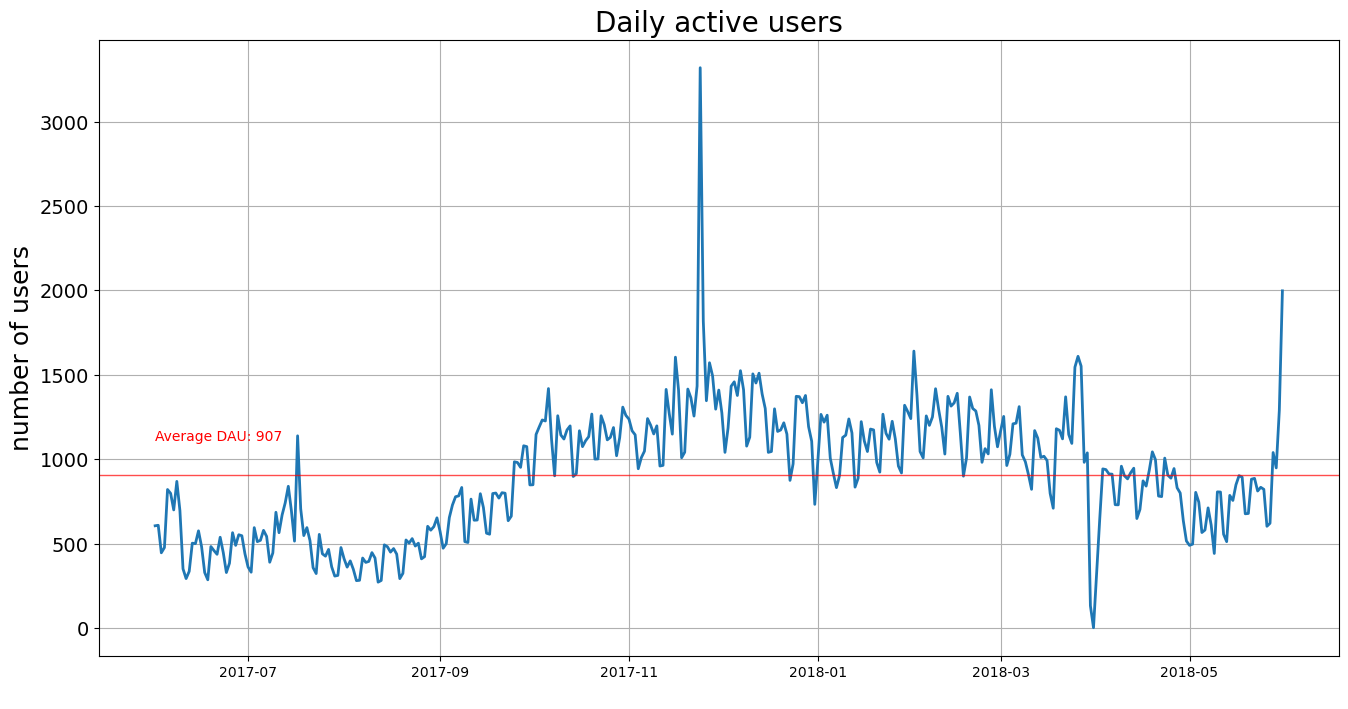

In [14]:
dau = visits.groupby('session_date').agg({'uid': 'nunique'}).reset_index()

plt.figure(figsize=(16,8))
ax = sns.lineplot(data=dau, x="session_date", y="uid", linewidth=2)
ax.grid(axis= 'both')

plt.axhline(y=int(dau_total), linewidth=1, color = 'red', alpha = 0.7)
ax.text(dau['session_date'].iloc[0], dau_total+200, f"Average DAU: {int(dau_total)}", color='red')


ax.set_title('Daily active users', fontsize=20)
ax.set_ylabel('number of users', fontsize = 18)
ax.tick_params(axis='y', labelsize=14)
ax.set_xlabel(' ');

We see that from October to April our active daily users are above average number with peak in December - this peak could be explained by different New Year related activities. And the user activity period from october till April matches the concert and theatrical season (and the bad weather). Drop in April could be explained by the end of the concert season (and the start of good weather).

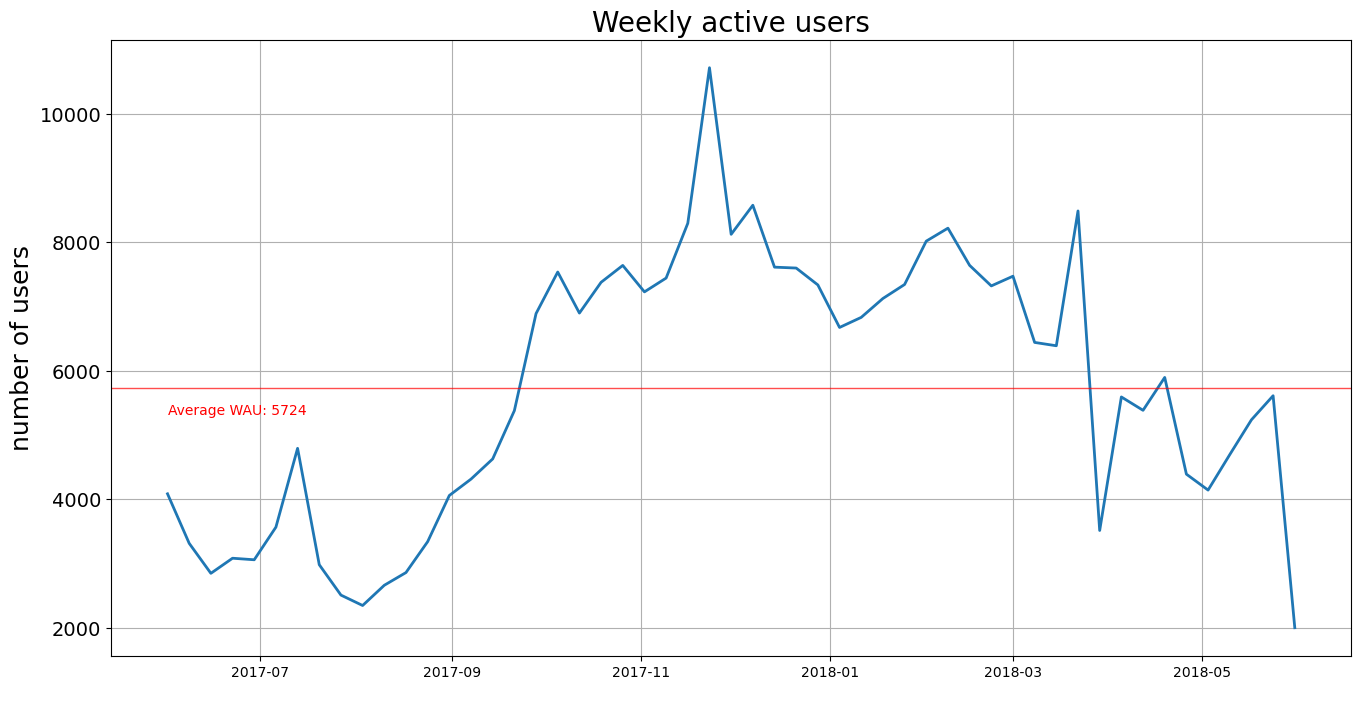

In [15]:
wau = visits.groupby('session_week').agg({'uid': 'nunique'}).reset_index()

plt.figure(figsize=(16,8))
ax = sns.lineplot(data=wau, x="session_week", y="uid", linewidth=2)
ax.grid(axis= 'both')

plt.axhline(y=int(wau_total), linewidth=1, color = 'red', alpha = 0.7)
ax.text(wau['session_week'].iloc[0], wau_total-400, f"Average WAU: {int(wau_total)}", color='red')


ax.set_title('Weekly active users', fontsize=20)
ax.set_ylabel('number of users', fontsize = 18)
ax.tick_params(axis='y', labelsize=14)
ax.set_xlabel(' ');

Weekly active user graph gives us the same trend - rise above average number in October, peak in December and drop in April.

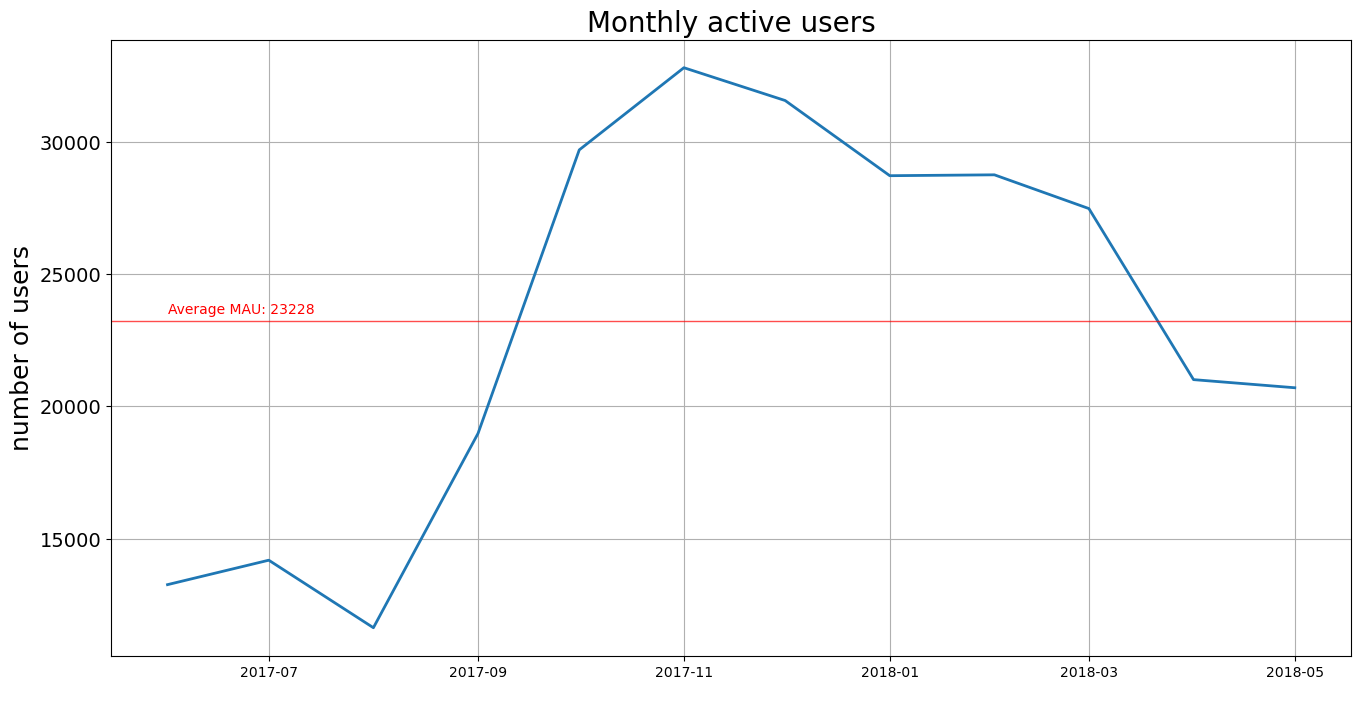

In [16]:
mau = visits.groupby('session_month').agg({'uid': 'nunique'}).reset_index()

plt.figure(figsize=(16,8))
ax = sns.lineplot(data=mau, x="session_month", y="uid", linewidth=2)
ax.grid(axis= 'both')

plt.axhline(y=int(mau_total), linewidth=1, color = 'red', alpha = 0.7)
ax.text(mau['session_month'].iloc[0], mau_total+300, f"Average MAU: {int(mau_total)}", color='red')


ax.set_title('Monthly active users', fontsize=20)
ax.set_ylabel('number of users', fontsize = 18)
ax.tick_params(axis='y', labelsize=14)
ax.set_xlabel(' ');

Same dynamic in monthly active users - when there is more of activities going on more users came to the service.

### 2. How many sessions are there per day? (One user might have more than one session.)

In [17]:
sessions_per_user = visits.groupby(['session_date']).agg(
    {'uid': ['nunique','count']}
)
sessions_per_user.columns = ['n_users', 'n_sessions']
sessions_per_user['sessions_per_user'] = (
    sessions_per_user['n_sessions'] / sessions_per_user['n_users']
)
sessions_per_user.head()

,n_users,n_sessions,sessions_per_user
session_date,,,
2017-06-01,605,664,1.097521
2017-06-02,608,658,1.082237
2017-06-03,445,477,1.071910
2017-06-04,476,510,1.071429
2017-06-05,820,893,1.089024


In [18]:
avg_session_per_user = sessions_per_user.sessions_per_user.mean()
print('Average number of sessions per user is', round(avg_session_per_user, 2))

Average number of sessions per user is 1.08


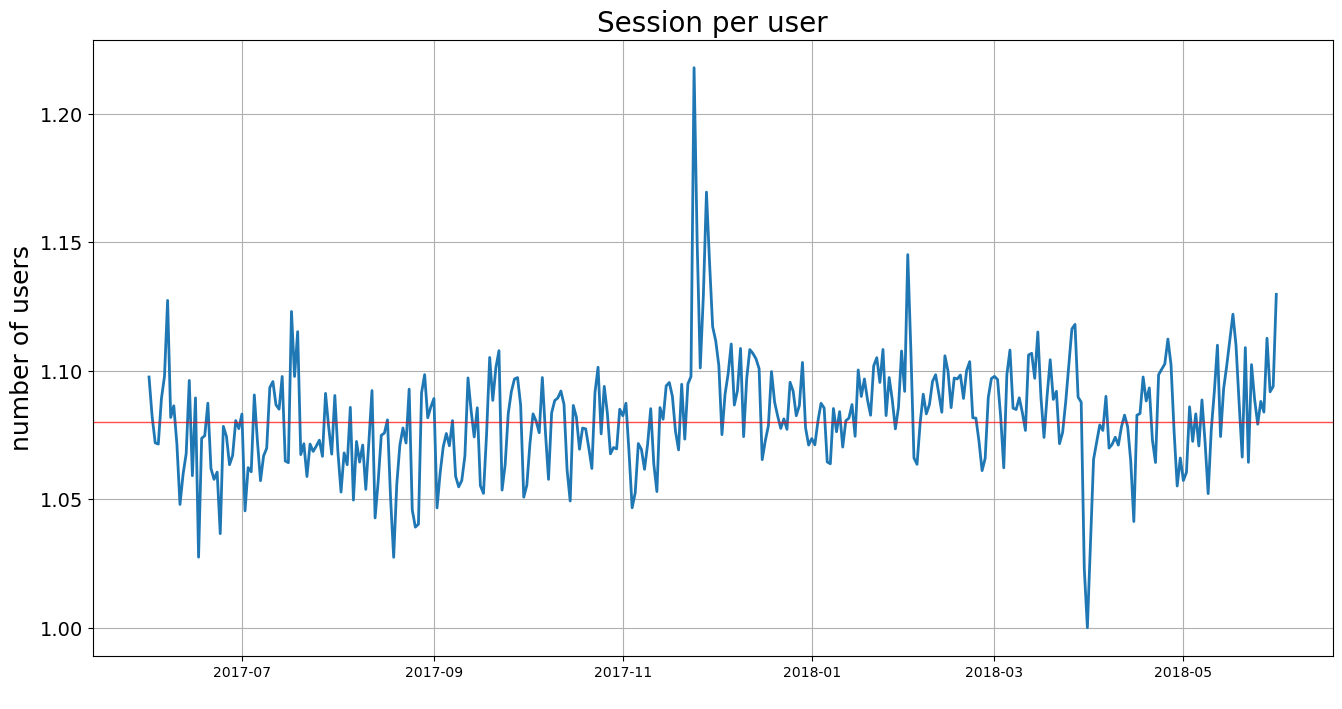

In [19]:
plt.figure(figsize=(16,8))
ax = sns.lineplot(data=sessions_per_user, x="session_date", y="sessions_per_user", linewidth=2)
ax.grid(axis= 'both')

plt.axhline(y=round(avg_session_per_user,2), linewidth=1, color = 'red', alpha = 0.7)


ax.set_title('Session per user', fontsize=20)
ax.set_ylabel('number of users', fontsize = 18)
ax.tick_params(axis='y', labelsize=14)
ax.set_xlabel(' ');

Number of sessions per user doesn't vary that much - the highest number is just above 1.2 and the lowest is 1. 

### 3. What is the length of each session?

Let's see how long the sessions are on average. 

For that we need to calculate all of sessions durations and look at general distribution. 

In [20]:
visits['session_duration_sec'] = (visits['end_ts'] - visits['start_ts']).dt.seconds
visits.head()


,device,end_ts,source_id,start_ts,uid,session_year,session_month,session_week,session_date,session_duration_sec
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-01-01,2017-12-01,2017-12-14,2017-12-20,1080
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-01-01,2018-02-01,2018-02-15,2018-02-19,1680
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-01-01,2017-07-01,2017-06-29,2017-07-01,0
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-01-01,2018-05-01,2018-05-17,2018-05-20,1440
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-01-01,2017-12-01,2017-12-21,2017-12-27,0


In [21]:
visits['session_duration_sec'].describe()

count    359400.000000
mean        643.506489
std        1016.334786
min           0.000000
25%         120.000000
50%         300.000000
75%         840.000000
max       84480.000000
Name: session_duration_sec, dtype: float64

There are some session with "0" duration. Let's see if there are many of session like this.

In [22]:
len(visits[visits['session_duration_sec']==0])
len(visits[visits['session_duration_sec']==0])/len(visits)*100

35794

9.959376739009459

It's almost 10% of all sessions. It already a considerable amount, but for our analysis we will just filter them out. 

In [23]:
visits[visits['session_duration_sec'] >0]['session_duration_sec'].describe()

count    323606.000000
mean        714.684623
std        1047.052806
min          19.000000
25%         120.000000
50%         360.000000
75%         900.000000
max       84480.000000
Name: session_duration_sec, dtype: float64

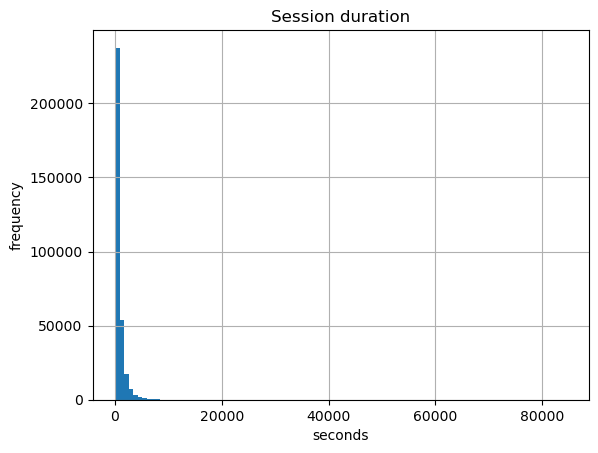

In [24]:
visits[visits['session_duration_sec'] >0]['session_duration_sec'].hist(bins=100)
plt.title('Session duration')
plt.xlabel('seconds')
plt.ylabel('frequency');

As we can see the distribution is highly skewed and mean or median won't give us much information about average session duration. The best way to identify average is to find most common value.

In [25]:
visits[visits['session_duration_sec'] >0]['session_duration_sec'].value_counts()

60       53029
120      35748
180      26672
240      21085
300      17005
         ...  
17820        1
18480        1
14340        1
23400        1
16320        1
Name: session_duration_sec, Length: 311, dtype: int64

In [26]:
asl_mode = visits[visits['session_duration_sec'] >0]['session_duration_sec'].mode()
asl_mean = visits[visits['session_duration_sec'] >0]['session_duration_sec'].mean()
asl_median = visits[visits['session_duration_sec'] >0]['session_duration_sec'].median()
print('Most common value for session length is', float(asl_mode), 'seconds')
print('Mean session length is', round(asl_mean,2), 'seconds')
print('Median session length is', round(asl_median,2), 'seconds')

Most common value for session length is 60.0 seconds
Mean session length is 714.68 seconds
Median session length is 360.0 seconds


### 4. How often do users come back? What's the user retention rate?

In order to know how often users come back we need to find their first visit. 

In [27]:
first_session_date = visits.groupby(['uid'])['session_date'].min()
first_session_date.name = 'first_session_date'
visits = visits.join(first_session_date,on='uid')
visits.head(5)

,device,end_ts,source_id,start_ts,uid,session_year,session_month,session_week,session_date,session_duration_sec,first_session_date
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-01-01,2017-12-01,2017-12-14,2017-12-20,1080,2017-12-20
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-01-01,2018-02-01,2018-02-15,2018-02-19,1680,2018-02-19
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-01-01,2017-07-01,2017-06-29,2017-07-01,0,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-01-01,2018-05-01,2018-05-17,2018-05-20,1440,2018-03-09
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-01-01,2017-12-01,2017-12-21,2017-12-27,0,2017-12-27


In [28]:
visits['first_session_month'] = visits['first_session_date'].astype('datetime64[M]')
visits.head(5)

,device,end_ts,source_id,start_ts,uid,session_year,session_month,session_week,session_date,session_duration_sec,first_session_date,first_session_month
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-01-01,2017-12-01,2017-12-14,2017-12-20,1080,2017-12-20,2017-12-01
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-01-01,2018-02-01,2018-02-15,2018-02-19,1680,2018-02-19,2018-02-01
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-01-01,2017-07-01,2017-06-29,2017-07-01,0,2017-07-01,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-01-01,2018-05-01,2018-05-17,2018-05-20,1440,2018-03-09,2018-03-01
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-01-01,2017-12-01,2017-12-21,2017-12-27,0,2017-12-27,2017-12-01


The best way to track retention is cohort analysis - we'll form montly cohorts based on the moth when user first came to our service.

In [29]:
visits.pivot_table(
    index='first_session_month',
    columns='session_month',
    values='uid',
    aggfunc='nunique') 

session_month,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01
first_session_month,,,,,,,,,,,,
2017-06-01,13259.0,1043.0,713.0,814.0,909.0,947.0,809.0,766.0,694.0,674.0,539.0,596.0
2017-07-01,NaN,13140.0,737.0,674.0,738.0,765.0,633.0,596.0,601.0,510.0,376.0,361.0
2017-08-01,NaN,NaN,10181.0,783.0,640.0,639.0,510.0,448.0,370.0,402.0,284.0,265.0
2017-09-01,NaN,NaN,NaN,16704.0,1428.0,1156.0,847.0,658.0,632.0,599.0,404.0,381.0
2017-10-01,NaN,NaN,NaN,NaN,25977.0,2042.0,1357.0,1012.0,890.0,837.0,555.0,529.0
2017-11-01,NaN,NaN,NaN,NaN,NaN,27248.0,2133.0,1202.0,1054.0,919.0,638.0,594.0
2017-12-01,NaN,NaN,NaN,NaN,NaN,NaN,25268.0,1410.0,960.0,786.0,512.0,481.0
2018-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22624.0,1351.0,890.0,565.0,458.0
2018-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22197.0,1267.0,565.0,446.0


We'll add column `cohort_lifetime` describing cohort's age in month.

In [30]:
visits['cohort_lifetime'] = (
    (pd.to_datetime(visits['session_month']) - pd.to_datetime(visits['first_session_month']))
    / np.timedelta64(1,'M')).round().astype('int')
                                                                       


In [31]:
visits

,device,end_ts,source_id,start_ts,uid,session_year,session_month,session_week,session_date,session_duration_sec,first_session_date,first_session_month,cohort_lifetime
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-01-01,2017-12-01,2017-12-14,2017-12-20,1080,2017-12-20,2017-12-01,0
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-01-01,2018-02-01,2018-02-15,2018-02-19,1680,2018-02-19,2018-02-01,0
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-01-01,2017-07-01,2017-06-29,2017-07-01,0,2017-07-01,2017-07-01,0
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-01-01,2018-05-01,2018-05-17,2018-05-20,1440,2018-03-09,2018-03-01,2
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-01-01,2017-12-01,2017-12-21,2017-12-27,0,2017-12-27,2017-12-01,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
359395,desktop,2017-07-29 19:07:19,2,2017-07-29 19:07:00,18363291481961487539,2017-01-01,2017-07-01,2017-07-27,2017-07-29,19,2017-07-29,2017-07-01,0
359396,touch,2018-01-25 17:38:19,1,2018-01-25 17:38:00,18370831553019119586,2018-01-01,2018-01-01,2018-01-25,2018-01-25,19,2018-01-25,2018-01-01,0
359397,desktop,2018-03-03 10:12:19,4,2018-03-03 10:12:00,18387297585500748294,2018-01-01,2018-03-01,2018-03-01,2018-03-03,19,2018-03-03,2018-03-01,0
359398,desktop,2017-11-02 10:12:19,5,2017-11-02 10:12:00,18388616944624776485,2017-01-01,2017-11-01,2017-11-02,2017-11-02,19,2017-11-02,2017-11-01,0


Now we'll group our visit table by first session month and cohort lifetime and calculate number of unique users in each cohort in each month.

In [32]:
cohorts = visits.groupby(['first_session_month', 'cohort_lifetime']).agg({'uid': 'nunique'}).reset_index()
cohorts

,first_session_month,cohort_lifetime,uid
0,2017-06-01,0,13259
1,2017-06-01,1,1043
2,2017-06-01,2,713
3,2017-06-01,3,814
4,2017-06-01,4,909
...,...,...,...
73,2018-03-01,1,861
74,2018-03-01,2,557
75,2018-04-01,0,15709
76,2018-04-01,1,760


The last piece of unformation that we need for calculating retention is how many users were in each cohort in the beginning.

In [33]:
initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_session_month', 'uid']]
initial_users_count = initial_users_count.rename(columns={'uid': 'cohort_users'}) 
initial_users_count

,first_session_month,cohort_users
0,2017-06-01,13259
12,2017-07-01,13140
23,2017-08-01,10181
33,2017-09-01,16704
42,2017-10-01,25977
50,2017-11-01,27248
57,2017-12-01,25268
63,2018-01-01,22624
68,2018-02-01,22197
72,2018-03-01,20589


Here we also see the same growth in users that we saw in DAU/WAU/MAU metrics - cohorts from Ocrober till March are bigger than other cohorts.

In [34]:
cohorts = cohorts.merge(initial_users_count, on='first_session_month') 
cohorts

,first_session_month,cohort_lifetime,uid,cohort_users
0,2017-06-01,0,13259,13259
1,2017-06-01,1,1043,13259
2,2017-06-01,2,713,13259
3,2017-06-01,3,814,13259
4,2017-06-01,4,909,13259
...,...,...,...,...
73,2018-03-01,1,861,20589
74,2018-03-01,2,557,20589
75,2018-04-01,0,15709,15709
76,2018-04-01,1,760,15709


We have all that we need and it's time to find out how long our visitors are staying with us.

In [35]:
cohorts['retention'] = cohorts['uid'] / cohorts['cohort_users'] 
cohorts

,first_session_month,cohort_lifetime,uid,cohort_users,retention
0,2017-06-01,0,13259,13259,1.000000
1,2017-06-01,1,1043,13259,0.078664
2,2017-06-01,2,713,13259,0.053775
3,2017-06-01,3,814,13259,0.061392
4,2017-06-01,4,909,13259,0.068557
...,...,...,...,...,...
73,2018-03-01,1,861,20589,0.041818
74,2018-03-01,2,557,20589,0.027053
75,2018-04-01,0,15709,15709,1.000000
76,2018-04-01,1,760,15709,0.048380


And in order to be able to look at the whole picture let's visualise retention rate by heatmap.

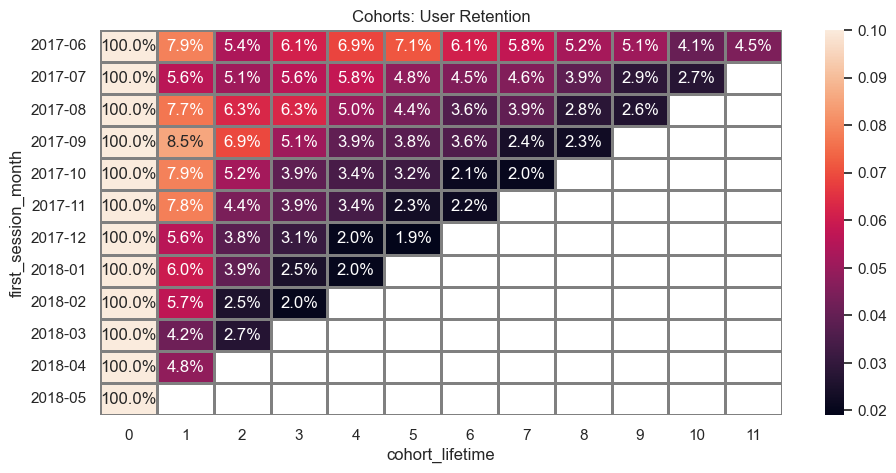

In [36]:
retention_pivot = cohorts.pivot_table(
    index='first_session_month',
    columns='cohort_lifetime',
    values='retention',
    aggfunc='sum')

retention_pivot.index = retention_pivot.index.to_series().dt.strftime('%Y-%m')

sns.set(style='white')
plt.figure(figsize=(11, 5))
plt.title('Cohorts: User Retention')
sns.heatmap(retention_pivot, 
            annot=True, 
            fmt='.1%', 
            linewidths=1, 
            vmax=0.1, 
            linecolor='gray');

In [37]:
retention_pivot

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_session_month,,,,,,,,,,,,
2017-06,1.0,0.078664,0.053775,0.061392,0.068557,0.071423,0.061015,0.057772,0.052342,0.050833,0.040652,0.044951
2017-07,1.0,0.056088,0.051294,0.056164,0.058219,0.048174,0.045358,0.045738,0.038813,0.028615,0.027473,NaN
2017-08,1.0,0.076908,0.062862,0.062764,0.050093,0.044004,0.036342,0.039485,0.027895,0.026029,NaN,NaN
2017-09,1.0,0.085489,0.069205,0.050706,0.039392,0.037835,0.035860,0.024186,0.022809,NaN,NaN,NaN
2017-10,1.0,0.078608,0.052239,0.038958,0.034261,0.032221,0.021365,0.020364,NaN,NaN,NaN,NaN
2017-11,1.0,0.078281,0.044113,0.038682,0.033727,0.023415,0.021800,NaN,NaN,NaN,NaN,NaN
2017-12,1.0,0.055802,0.037993,0.031107,0.020263,0.019036,NaN,NaN,NaN,NaN,NaN,NaN
2018-01,1.0,0.059715,0.039339,0.024973,0.020244,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02,1.0,0.057080,0.025454,0.020093,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


What do we see in this heatmap?

1. All cohorts show a significant drop right after the month where our service was used for the first time. And almost every cohort keep showing decrease every next month.
2. Except for the first cohort attracted in June 2017 - this cohort shows slight increase from the third month of its lifetime till fifth month and then also starts to decrease as all other cohorts do. But still this cohort is the most successful one in terms of retention - every month it shows better retention than other cohorts.
3. The overall trend here is that almost every time next cohort shows lower retention then the previous one.

### Product summary

We needed to look at basic but important user metrics in order to understand how our product is being used.

#### 1. DAU/WAU/MAU
* DAU is 907
* WAU is 5724 with sticky factor 15.9%
* MAU is 23228 with sticky factor 3.9%

The average numbers of active users seem to be ok, but if we look at the sticky factor we can say that our visitors don't came back very often - weekly sticky factor is only 15.9% and monthly sticky factor is much lower - 3.9%.
If we look at these metrics in dynamics we can see one trend - rise above average number in October, peak in December and drop in April.
December peak could be explained by different New Year related activities. And the user activity period from October till April matches the concert and theatrical season (and the bad weather). Drop in April could be explained by the end of the concert season (and the start of good weather).

#### 2. Average number of sessions per user daily

Average number of sessions per user is 1.08. And in dynamics this number doesn't vary much - the highest number of sessions per user is just above 1.2 and the lowest is 1.

#### 3. Average session length

Most common value for session length is 60 seconds and median session length is 360 seconds that means that 50% of visitors are using Yandex.Afisha for longer than 6 minutes. 

#### 4. What's the user retention rate?

All cohorts show a significant drop right after the month where our service was used for the first time. And almost every cohort keep showing decrease every next month.
Except for the first cohort attracted in June 2017 - this cohort shows slight increase from the third month of its lifetime till fifth month and then also starts to decrease as all other cohorts do. But still the first cohort is the most successful one in terms of retention - every month it shows better retention than other cohorts.
The overall trend here is that almost every time the next cohort shows lower retention than the previous one. 

As we see it doesn't align with growth in active users from October till March so it has something to do with our service performance or user's engagement - new visitors attracted into it, but for some reason they are not staying for long. This problem should be investigated. 



### Sales

### 1. When do people start buying?

Now we want to look at the orders dataset. And first of all we need to create column with date of order.

In [38]:
orders['order_date'] = orders['buy_ts'].astype('datetime64[D]')
orders
orders.info()

,buy_ts,revenue,uid,order_date
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01
...,...,...,...,...
50410,2018-05-31 23:50:00,4.64,12296626599487328624,2018-05-31
50411,2018-05-31 23:50:00,5.80,11369640365507475976,2018-05-31
50412,2018-05-31 23:54:00,0.30,1786462140797698849,2018-05-31
50413,2018-05-31 23:56:00,3.67,3993697860786194247,2018-05-31


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   buy_ts      50415 non-null  datetime64[ns]
 1   revenue     50415 non-null  float64       
 2   uid         50415 non-null  uint64        
 3   order_date  50415 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(1), uint64(1)
memory usage: 1.5 MB


And then we can find the date when the first order was made.

In [39]:
first_order_date = orders.groupby(['uid'])['order_date'].min()
first_order_date.name = 'first_order_date'
orders = orders.join(first_order_date,on='uid')
orders.sample(10)

,buy_ts,revenue,uid,order_date,first_order_date
9170,2017-09-26 15:24:00,1.10,10946615764049766437,2017-09-26,2017-09-26
24904,2017-12-19 14:37:00,1.47,10621762973534959410,2017-12-19,2017-12-19
43291,2018-04-06 13:55:00,2.44,4107832543971707129,2018-04-06,2018-04-06
31807,2018-01-30 11:36:00,0.85,4797590919627694628,2018-01-30,2018-01-30
30152,2018-01-19 23:19:00,1.22,18375860173040250754,2018-01-19,2017-07-21
21526,2017-12-02 15:28:00,0.37,11401377186810902874,2017-12-02,2017-12-02
20654,2017-11-28 13:52:00,0.06,14377772179142763821,2017-11-28,2017-11-28
28530,2018-01-08 16:14:00,1.75,13975116869990132577,2018-01-08,2018-01-08
21022,2017-11-29 22:33:00,7.94,11917901801105556832,2017-11-29,2017-11-29
36225,2018-02-21 18:12:00,1.22,14691451025075033977,2018-02-21,2018-01-12


We already have dataframe with first session date from previous steps so we can use it now in order to calculate convertion - number of days from first visit to the first order.

In [40]:
orders = orders.join(first_session_date,on='uid')
orders.head()

,buy_ts,revenue,uid,order_date,first_order_date,first_session_date
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01,2017-06-01


In [41]:
orders['conversion']=(
    (pd.to_datetime(orders['first_order_date'])-pd.to_datetime(orders['first_session_date']))
    /np.timedelta64(1,'D')).astype('int')
orders

,buy_ts,revenue,uid,order_date,first_order_date,first_session_date,conversion
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01,2017-06-01,0
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01,2017-06-01,0
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01,2017-06-01,0
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01,2017-06-01,0
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01,2017-06-01,0
...,...,...,...,...,...,...,...
50410,2018-05-31 23:50:00,4.64,12296626599487328624,2018-05-31,2018-05-31,2018-05-31,0
50411,2018-05-31 23:50:00,5.80,11369640365507475976,2018-05-31,2018-05-31,2018-05-31,0
50412,2018-05-31 23:54:00,0.30,1786462140797698849,2018-05-31,2018-05-31,2018-05-31,0
50413,2018-05-31 23:56:00,3.67,3993697860786194247,2018-05-31,2018-05-31,2017-10-23,220


Let's look at the distribution of conversion

In [42]:
orders.conversion.describe()

count    50415.000000
mean        17.611227
std         46.469172
min          0.000000
25%          0.000000
50%          0.000000
75%          4.000000
max        363.000000
Name: conversion, dtype: float64

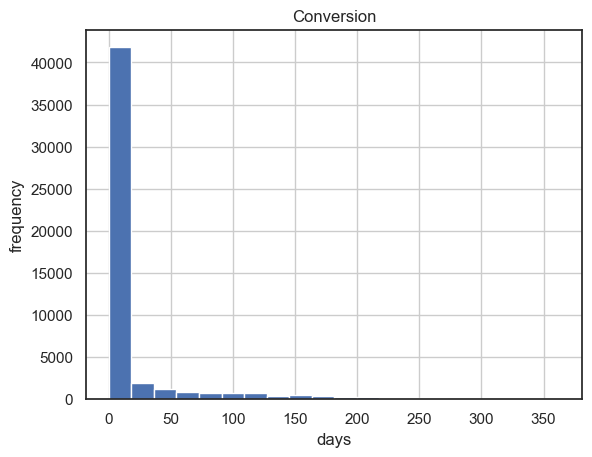

In [43]:
orders.conversion.hist(bins=20)
plt.title('Conversion')
plt.xlabel('days')
plt.ylabel('frequency');

Looks like here we have good results - median conversion is 0 so at least 50% of orders were made on the day of first visit. Now let's look at general conversion - what percentage of visitors made purchase in our service.

In [44]:
print('The overall conversion is {:.1%}'.format(orders['uid'].nunique()/visits['uid'].nunique()))

The overall conversion is 16.0%


16% of visitors converted to clients.

### 2. How many orders do people make during a given period of time?

Let's conduct a cohort analysis of orders. In order to do that we need to create columns with month of first order and month of order.

In [45]:
orders['order_month'] = orders['buy_ts'].astype('datetime64[M]')
orders['first_order_month'] = orders['first_order_date'].astype('datetime64[M]')
orders.head()

,buy_ts,revenue,uid,order_date,first_order_date,first_session_date,conversion,order_month,first_order_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01,2017-06-01,0,2017-06-01,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01,2017-06-01,0,2017-06-01,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01,2017-06-01,0,2017-06-01,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01,2017-06-01,0,2017-06-01,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01,2017-06-01,0,2017-06-01,2017-06-01


We also need to calculate sizes of cohorts

In [46]:
cohort_sizes = orders.groupby('first_order_month').agg({'uid': 'nunique'}).reset_index()
cohort_sizes.columns=['first_order_month','cohort_size']
cohort_sizes

,first_order_month,cohort_size
0,2017-06-01,2023
1,2017-07-01,1923
2,2017-08-01,1370
3,2017-09-01,2581
4,2017-10-01,4340
5,2017-11-01,4081
6,2017-12-01,4383
7,2018-01-01,3373
8,2018-02-01,3651
9,2018-03-01,3533


Oh! Here we also see increase in numbers from October to March!

Let's create additionnal dataframe for cohorts with month of first order, month of order and numder of orders

In [47]:
order_cohorts = orders.groupby(['first_order_month','order_month'])['revenue'].count().reset_index()
order_cohorts.columns=['first_order_month','order_month','orders']
order_cohorts.head(5)

,first_order_month,order_month,orders
0,2017-06-01,2017-06-01,2354
1,2017-06-01,2017-07-01,177
2,2017-06-01,2017-08-01,174
3,2017-06-01,2017-09-01,226
4,2017-06-01,2017-10-01,292


We'll merge cohort dataframe with cohorts sizes

In [48]:
order_cohorts = order_cohorts.merge(cohort_sizes,on=['first_order_month'])
order_cohorts.head()

,first_order_month,order_month,orders,cohort_size
0,2017-06-01,2017-06-01,2354,2023
1,2017-06-01,2017-07-01,177,2023
2,2017-06-01,2017-08-01,174,2023
3,2017-06-01,2017-09-01,226,2023
4,2017-06-01,2017-10-01,292,2023


Now we can calculate number of orders per buyer in cohort.

In [49]:
order_cohorts['age_month'] = ((order_cohorts['order_month'] - order_cohorts['first_order_month']) 
                              / np.timedelta64(1,'M')).round()
order_cohorts['orders_per_buyer']=order_cohorts['orders']/order_cohorts['cohort_size']
order_cohorts

,first_order_month,order_month,orders,cohort_size,age_month,orders_per_buyer
0,2017-06-01,2017-06-01,2354,2023,0.0,1.163618
1,2017-06-01,2017-07-01,177,2023,1.0,0.087494
2,2017-06-01,2017-08-01,174,2023,2.0,0.086011
3,2017-06-01,2017-09-01,226,2023,3.0,0.111715
4,2017-06-01,2017-10-01,292,2023,4.0,0.144340
...,...,...,...,...,...,...
74,2018-03-01,2018-05-01,176,3533,2.0,0.049816
75,2018-04-01,2018-04-01,2495,2276,0.0,1.096221
76,2018-04-01,2018-05-01,195,2276,1.0,0.085677
77,2018-05-01,2018-05-01,3249,2988,0.0,1.087349


And present this information in a better way - so we can compare cohorts in months of their lifetime by the orders per buyers.

In [50]:
cohort_piv=order_cohorts.pivot_table(
    index='first_order_month', 
    columns='age_month', 
    values='orders_per_buyer', 
    aggfunc='sum')

cohort_piv.round(2).fillna('')

age_month,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0
first_order_month,,,,,,,,,,,,
2017-06-01,1.16,0.09,0.09,0.11,0.14,0.11,0.14,0.09,0.1,0.08,0.05,0.04
2017-07-01,1.14,0.05,0.06,0.05,0.04,0.04,0.03,0.03,0.03,0.01,0.03,
2017-08-01,1.12,0.08,0.07,0.06,0.06,0.05,0.04,0.06,0.03,0.03,,
2017-09-01,1.14,0.08,0.06,0.06,0.03,0.04,0.04,0.02,0.02,,,
2017-10-01,1.14,0.07,0.04,0.03,0.03,0.02,0.02,0.03,,,,
2017-11-01,1.18,0.1,0.04,0.05,0.03,0.01,0.02,,,,,
2017-12-01,1.15,0.06,0.05,0.04,0.02,0.02,,,,,,
2018-01-01,1.12,0.07,0.05,0.02,0.02,,,,,,,
2018-02-01,1.12,0.06,0.02,0.02,,,,,,,,


And if we want to know which cohort showed better overall results we can calculate cumulative sum of numbers of orders.

In [51]:
cohort_piv=order_cohorts.pivot_table(
    index='first_order_month', 
    columns='age_month', 
    values='orders_per_buyer', 
    aggfunc='sum'
).cumsum(axis=1)

cohort_piv.round(2).fillna('')

age_month,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0
first_order_month,,,,,,,,,,,,
2017-06-01,1.16,1.25,1.34,1.45,1.59,1.7,1.84,1.92,2.03,2.1,2.15,2.19
2017-07-01,1.14,1.19,1.25,1.31,1.34,1.39,1.42,1.44,1.47,1.49,1.51,
2017-08-01,1.12,1.2,1.27,1.33,1.39,1.44,1.47,1.53,1.56,1.6,,
2017-09-01,1.14,1.22,1.28,1.35,1.37,1.42,1.46,1.48,1.5,,,
2017-10-01,1.14,1.22,1.25,1.28,1.31,1.34,1.35,1.38,,,,
2017-11-01,1.18,1.28,1.32,1.37,1.41,1.42,1.45,,,,,
2017-12-01,1.15,1.21,1.26,1.3,1.32,1.34,,,,,,
2018-01-01,1.12,1.19,1.24,1.25,1.28,,,,,,,
2018-02-01,1.12,1.18,1.21,1.22,,,,,,,,


We see that the first cohort is the best of all cohorts and has 2.19 orders per buyer for the whole time. Second best is our August cohort with 1.6 orders. Other cohorts show from 1 to 1.5 orders per buyer.

### 3. What is the average purchase size?

Now we want to know what is the average purchase size. 

First, we'll take a look at the general distribution in `revenue` column.

In [52]:
orders.revenue.describe()

count    50415.000000
mean         4.999647
std         21.818359
min          0.000000
25%          1.220000
50%          2.500000
75%          4.890000
max       2633.280000
Name: revenue, dtype: float64

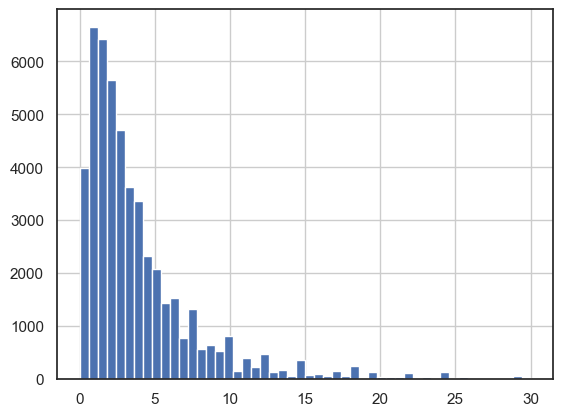

In [53]:
orders.revenue.hist(bins=50, range=(0, 30));

We see that distribution is highly skewed to the left - most of the values (75% of them) are located between 0 and 5.
Mean overall check is 4.99 and median is 2.5.

And what woud be average check in cohorts?

In [54]:
avg_check_cohort = orders.groupby(['first_order_month','order_month'])['revenue'].mean().reset_index()
avg_check_cohort['age_month'] = (
    (avg_check_cohort['order_month'] - avg_check_cohort['first_order_month']) / np.timedelta64(1,'M')).round()
avg_check_cohort


,first_order_month,order_month,revenue,age_month
0,2017-06-01,2017-06-01,4.060106,0.0
1,2017-06-01,2017-07-01,5.547006,1.0
2,2017-06-01,2017-08-01,5.088161,2.0
3,2017-06-01,2017-09-01,8.545575,3.0
4,2017-06-01,2017-10-01,7.084178,4.0
...,...,...,...,...
74,2018-03-01,2018-05-01,6.334489,2.0
75,2018-04-01,2018-04-01,4.248774,0.0
76,2018-04-01,2018-05-01,6.204718,1.0
77,2018-05-01,2018-05-01,4.286168,0.0


If we use pivot table this information would be more readable.

In [55]:
avg_cohort_piv=avg_check_cohort.pivot_table(
    index='first_order_month', 
    columns='age_month', 
    values='revenue', 
    aggfunc='mean')

avg_cohort_piv.round(2).fillna('')

age_month,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0
first_order_month,,,,,,,,,,,,
2017-06-01,4.06,5.55,5.09,8.55,7.08,6.83,6.97,6.76,5.28,8.01,12.04,6.04
2017-07-01,5.29,6.45,9.99,6.64,4.72,3.66,3.79,5.45,5.35,11.79,5.65,
2017-08-01,4.72,5.99,6.28,6.62,7.96,6.27,5.89,7.11,8.7,5.6,,
2017-09-01,4.97,13.17,8.35,62.57,15.43,15.32,16.77,11.21,7.79,,,
2017-10-01,4.37,7.41,5.13,5.59,5.1,5.07,4.28,4.01,,,,
2017-11-01,4.37,4.1,4.47,6.28,4.44,3.73,4.6,,,,,
2017-12-01,4.11,4.23,20.07,26.08,15.95,14.11,,,,,,
2018-01-01,3.69,4.44,6.45,7.52,2.71,,,,,,,
2018-02-01,3.71,4.58,3.45,3.87,,,,,,,,


We also can visualize how average check changed in time for each cohort.

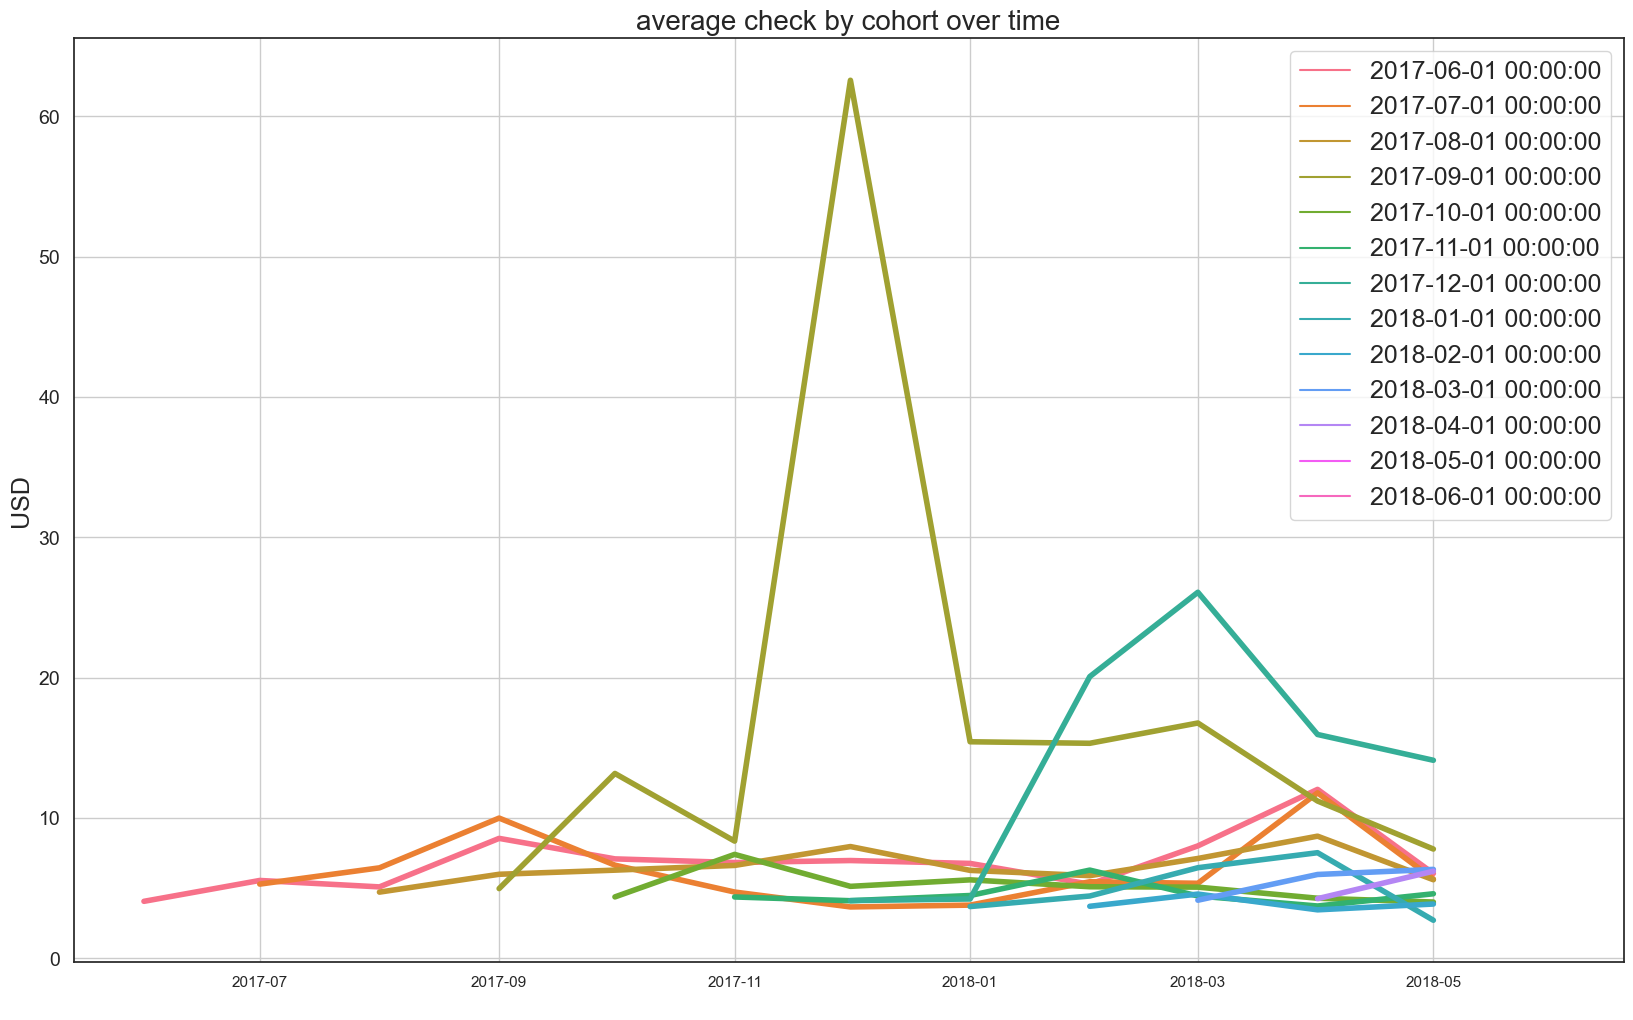

In [56]:
plt.figure(figsize=(20,12))
ax = sns.lineplot(data=avg_check_cohort, 
                  x="order_month", 
                  y="revenue",
                  hue="first_order_month", 
                  linewidth=4)
ax.grid(axis='both')
ax.set_title('average check by cohort over time', fontsize=20)
legend = ax.legend(fontsize=18)
ax.set_ylabel('USD', fontsize = 18)
ax.tick_params(axis='y', labelsize=14)
ax.set_xlabel(' ');



In the graph we can immediately spot a peak in December for September's cohort - its average check was more than 60$! 

Another peak is in March for December's cohort - its average check was more than 25$. 

Most of the other cohort's avegage checks were between 5 and 12$.

Now let's see how this average check changed in time.

In [57]:
avg_check_monthly = avg_check_cohort.groupby('order_month')['revenue'].mean().reset_index()
avg_check_monthly

,order_month,revenue
0,2017-06-01,4.060106
1,2017-07-01,5.417064
2,2017-08-01,5.416580
3,2017-09-01,7.373021
4,2017-10-01,7.509780
5,2017-11-01,6.381988
6,2017-12-01,13.500188
7,2018-01-01,6.278274
8,2018-02-01,7.949637
9,2018-03-01,8.800446


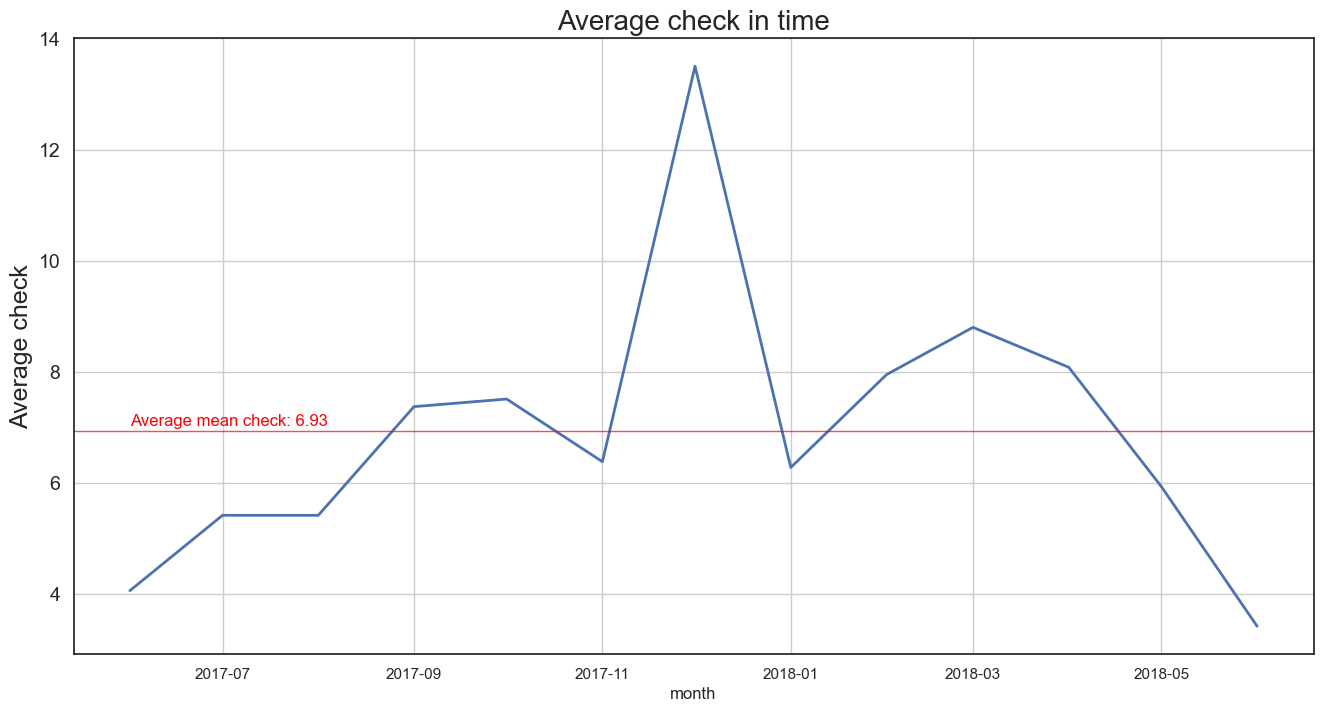

In [58]:
avg_check_mean = avg_check_monthly.revenue.mean()
plt.figure(figsize=(16,8))
ax = sns.lineplot(data=avg_check_monthly, x="order_month", y="revenue", linewidth=2)
ax.grid(axis= 'both')

plt.axhline(y=avg_check_mean, linewidth=1, color = 'red', alpha = 0.7)
ax.text(avg_check_monthly['order_month'].iloc[0], 
        avg_check_mean+0.1, f"Average mean check: {round(avg_check_mean, 2)}", color='red')


ax.set_title('Average check in time', fontsize=20)
ax.set_ylabel('Average check', fontsize = 18)
ax.tick_params(axis='y', labelsize=14)
ax.set_xlabel('month');

We see rise above average in September, high peak in December (we already know that this happened because of the big orders of September's cohort, maybe they were inspired by upcoming New Year) and the smaller peak in March and then decrease which we saw in almost every time-sensitive graph.

Now let's see which cohort had better average check in genegal.

In [59]:
avg_check_by_cohort = avg_check_cohort.groupby('first_order_month')['revenue'].mean().reset_index()
avg_check_by_cohort

,first_order_month,revenue
0,2017-06-01,6.853978
1,2017-07-01,6.252011
2,2017-08-01,6.513505
3,2017-09-01,17.285688
4,2017-10-01,5.119685
5,2017-11-01,4.571543
6,2017-12-01,14.092359
7,2018-01-01,4.963399
8,2018-02-01,3.900908
9,2018-03-01,5.482008


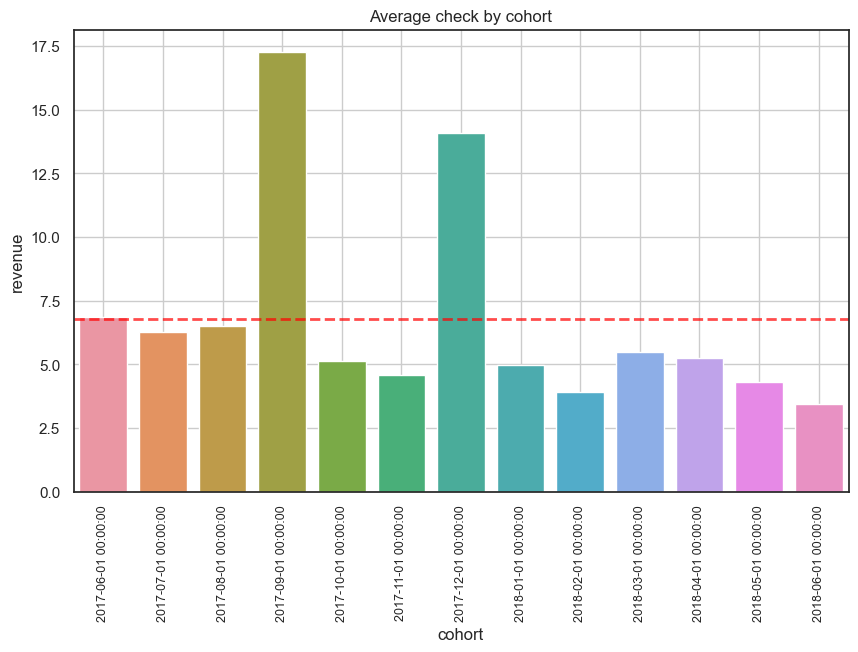

In [60]:
b = avg_check_by_cohort.revenue.mean()
plt.figure(figsize = (10,6))
ax = sns.barplot(data=avg_check_by_cohort, 
                 x='first_order_month', 
                 y='revenue',
                 linewidth=1)
ax.grid(axis='both')

plt.axhline(y=b, linewidth=2, color = 'red', alpha = 0.7, linestyle = '--')


ax.set_title('Average check by cohort')
ax.set_xlabel('cohort')
ax.set_ylabel('revenue')

ax.set_xticklabels(avg_check_by_cohort.first_order_month, rotation=90, fontsize=9);

In [61]:
b

6.766768968639142

Here we have two clear winners - September(avg check 17.28) and December(avg check 14.09) cohorts - their average checks are noticeably bigger than average checks of other cohorts.

Another interesting thing that we would want to know - how would our ungrouped by cohorts revenue look like over time? Will we see the same trends there that we previously saw in cohort analysis?

In [62]:
average_revenue = orders.groupby('order_month')['revenue'].mean().reset_index()
average_revenue

,order_month,revenue
0,2017-06-01,4.060106
1,2017-07-01,5.306589
2,2017-08-01,4.847139
3,2017-09-01,5.416448
4,2017-10-01,4.928280
5,2017-11-01,4.783518
6,2017-12-01,5.852139
7,2018-01-01,4.112927
8,2018-02-01,4.840095
9,2018-03-01,5.413930


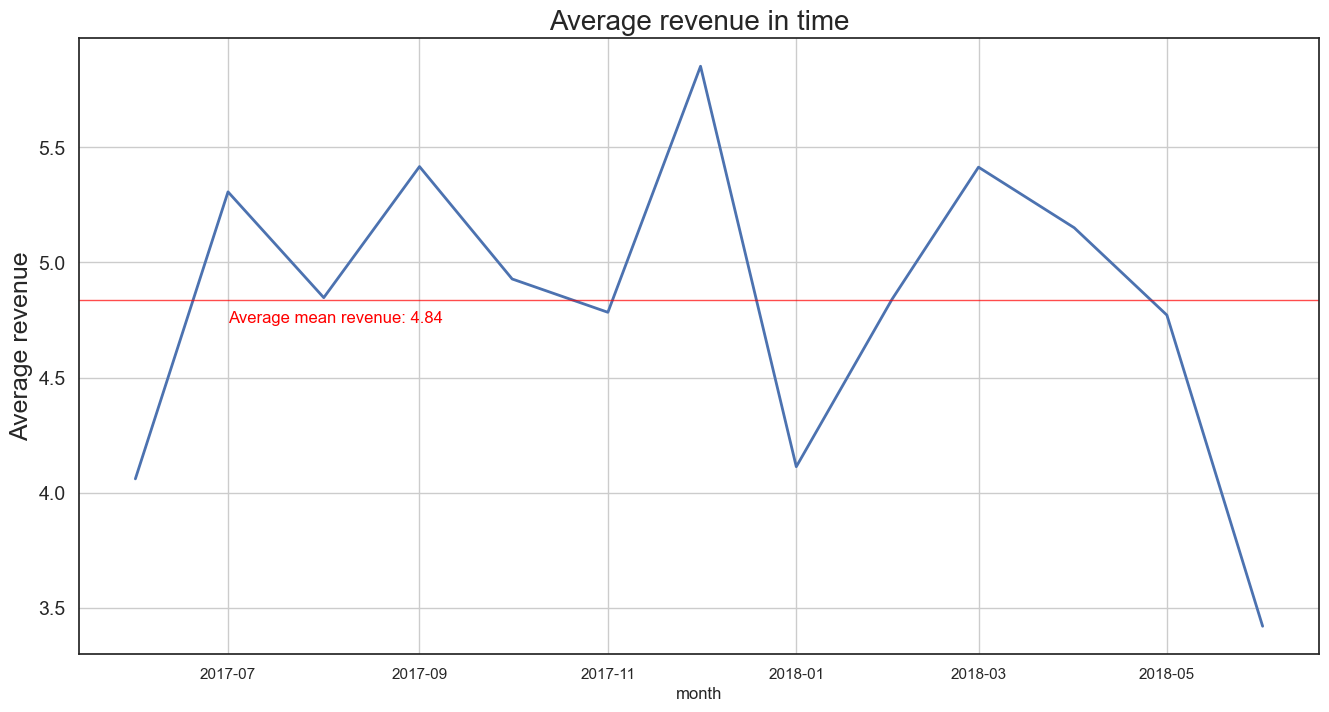

In [63]:
d = average_revenue.revenue.mean()
plt.figure(figsize=(16,8))
ax = sns.lineplot(data=average_revenue, x="order_month", y="revenue", linewidth=2)
ax.grid(axis= 'both')

plt.axhline(y=d, linewidth=1, color = 'red', alpha = 0.7)
ax.text(average_revenue['order_month'].iloc[1], 
        d-0.1, f"Average mean revenue: {round(d, 2)}", color='red')


ax.set_title('Average revenue in time', fontsize=20)
ax.set_ylabel('Average revenue', fontsize = 18)
ax.tick_params(axis='y', labelsize=14)
ax.set_xlabel('month');

And yes, we do see the same trend - peaks in September, December and March and drops in January and April-May. 
The numbers here are lower - overall average revenue vary from 3.4 to 5.8 and mean average revenue is 4.84$  

### 4. How much money do they bring? (LTV)

Now let's look how much money customers bring in cohorts - their average lifetime value.

For that we need to group our orders dataset by cohort and month of order and then sum up revenue. Add cohort size (we already have this small dataset from previous steps). And then divide every month revenue to the size of cohort - that's how we calculare client's ltv each month in every cohort.

In [64]:

ltv_cohort = orders.groupby(['first_order_month','order_month'])['revenue'].sum().reset_index()
ltv_cohort.columns = ['first_order_month','order_month','revenue']

ltv_cohort = ltv_cohort.merge(cohort_sizes,on=['first_order_month'])
ltv_cohort['age'] = ((ltv_cohort['order_month'] - ltv_cohort['first_order_month']) / np.timedelta64(1,'M')).round()
ltv_cohort['ltv'] = ltv_cohort['revenue']/ltv_cohort['cohort_size']
ltv_cohort

,first_order_month,order_month,revenue,cohort_size,age,ltv
0,2017-06-01,2017-06-01,9557.49,2023,0.0,4.724414
1,2017-06-01,2017-07-01,981.82,2023,1.0,0.485329
2,2017-06-01,2017-08-01,885.34,2023,2.0,0.437637
3,2017-06-01,2017-09-01,1931.30,2023,3.0,0.954671
4,2017-06-01,2017-10-01,2068.58,2023,4.0,1.022531
...,...,...,...,...,...,...
74,2018-03-01,2018-05-01,1114.87,3533,2.0,0.315559
75,2018-04-01,2018-04-01,10600.69,2276,0.0,4.657597
76,2018-04-01,2018-05-01,1209.92,2276,1.0,0.531599
77,2018-05-01,2018-05-01,13925.76,2988,0.0,4.660562


Then using pivot table we can transform this information into more readable format. We use here cumulative sum in order to see how much money customer in cohort has brought in the end of a period.

In [65]:
ltv_cohort_piv=ltv_cohort.pivot_table(
    index='first_order_month', 
    columns='age', 
    values='ltv', 
    aggfunc='sum'
).cumsum(axis=1)

ltv_cohort_piv.round(2).fillna('')
ltv_cohort_piv.index = ltv_cohort_piv.index.to_series().dt.strftime('%Y-%m')

age,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0
first_order_month,,,,,,,,,,,,
2017-06-01,4.72,5.21,5.65,6.6,7.62,8.36,9.31,9.89,10.45,11.05,11.62,11.88
2017-07-01,6.01,6.35,6.97,7.33,7.5,7.66,7.78,7.92,8.08,8.23,8.39,
2017-08-01,5.28,5.75,6.21,6.6,7.09,7.38,7.59,7.99,8.28,8.47,,
2017-09-01,5.64,6.76,7.28,11.26,11.66,12.31,13.01,13.25,13.44,,,
2017-10-01,5.00,5.54,5.73,5.89,6.04,6.16,6.24,6.36,,,,
2017-11-01,5.15,5.55,5.75,6.08,6.23,6.28,6.4,,,,,
2017-12-01,4.74,5.0,5.92,6.99,7.3,7.64,,,,,,
2018-01-01,4.14,4.43,4.73,4.88,4.94,,,,,,,
2018-02-01,4.16,4.44,4.51,4.59,,,,,,,,


Let's visualize it with a heatmap.

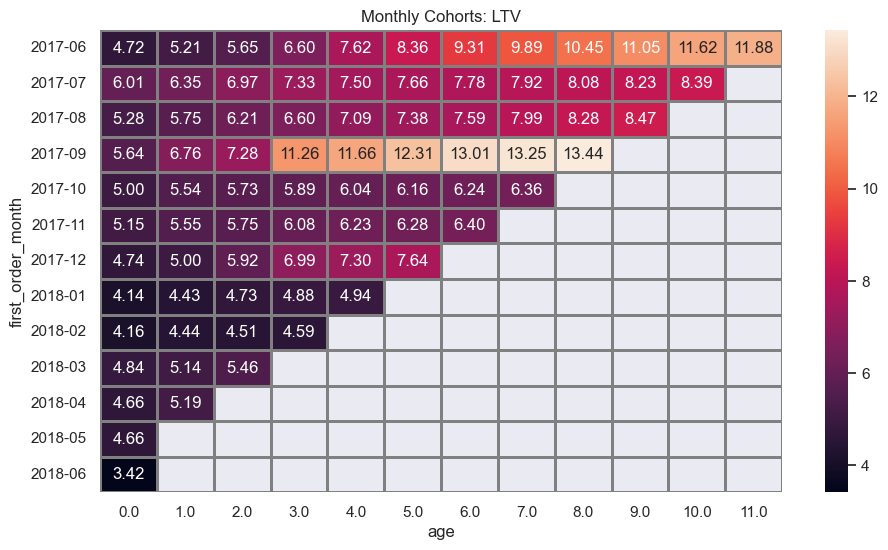

In [66]:
sns.set(style='dark')
plt.figure(figsize=(11, 6))

sns.heatmap(ltv_cohort_piv, 
            annot=True, 
            fmt = '.2f', 
            linewidths=1, 
            linecolor='gray')

plt.title('Monthly Cohorts: LTV');

LTV varies from 3.42 to 13.44USD.
The best cohort in terms of customer's ltv is the September cohort - each member of this cohort brought after 8 months 13.44 dollars. The second best is our first cohort - after 11 months a customer from this cohort brought the company 11.88 dollars.

### Sales summary

#### 1. When do people start buying?

Looks like here we have good results - median conversion is 0 so at least 50% of orders were made on the day of first visit. The overall conversion is 16.0% - 16% of our visitors became buyers.

#### 2. How many orders do people make during a given period of time?

We see that the first cohort is the best of all cohorts and has 2.19 orders per buyer for the whole time. Second best is our August cohort with 1.6 orders. Other cohorts show from 1 to 1.5 orders per buyer.
Here we also see an increase in the sizes of cohorts from October to March.

#### 3. What is the average purchase size?

We see that the general distribution in the revenue column is highly skewed to the left - most of the values (75% of them) are located between 0 and 5USD. Mean overall purchase is 4.99USD and median is 2.5.

If we look at the average check in different cohorts in time we see a peak in December for September's cohort - its average check was more than 60USD. Another peak is in March for December's cohort - its average check was more than 25USD.
Most of the other cohort's average checks were between 5 and 12USD.

If we compare cohorts overall average check we see two winners -  September cohort - its avg check 17.28USD and December cohort - its avg check 14.09USD. Mean average check of all cohorts is 6.76USD.

Another interesting thing that we would want to know - how would our ungrouped by cohorts monthly mean revenue looked like over time? Will we see the same trends there that we previously saw in cohort analysis?
And yes, we do see the same trend - peaks in September, December and March and drops in January and April-May. The numbers here are lower - overall average revenue vary from 3.4 to 5.8 and mean average revenue is 4.84USD

#### 4. How much money do they bring? (LTV)

LTV varies from 3.42 to 13.44USD. The best cohort in terms of customer's ltv is the September cohort - each member of this cohort brought after 8 months 13.44 dollars. The second best is our first cohort - after 11 months a customer from this cohort brought the company 11.88 dollars.

### Marketing

Now is the time to look at the marketing costs and understand if those spends were paid off.

### 1. How much money was spent? Overall, per source and over time.

In [67]:
costs.head()

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


Let's see how much money company spend in total.

In [68]:
overall_expenses = costs.costs.sum()
print('Total marketing cost is {} USD'.format(overall_expenses))

Total marketing cost is 329131.62 USD


In [69]:
overall_revenue = orders.revenue.sum()
print('Total revenue is {} USD'.format(round(overall_revenue,1)))

Total revenue is 252057.2 USD


Expenses are bigger than revenue. That is not a good sign, but let's not get ahead with conclusions and check everything first.

Now let's divide costs by source.

In [70]:
cost_by_source = costs.groupby('source_id')['costs'].sum().reset_index()
cost_by_source

,source_id,costs
0,1,20833.27
1,2,42806.04
2,3,141321.63
3,4,61073.60
4,5,51757.10
5,9,5517.49
6,10,5822.49


And visualize it.

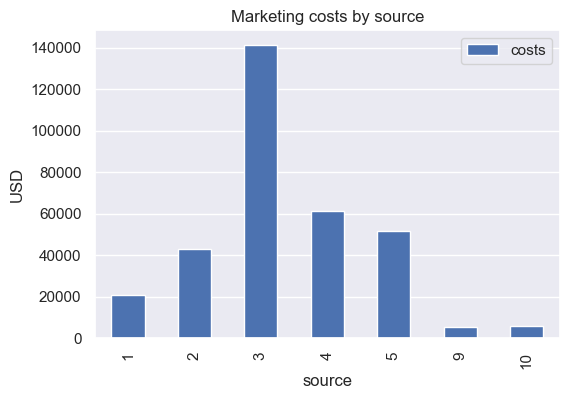

In [71]:
cost_by_source.plot(kind='bar', x = 'source_id', y = 'costs', figsize = (6,4)).grid(axis = 'y')
plt.title('Marketing costs by source')
plt.xlabel('source')
plt.ylabel('USD');

So the third source is the most expensive one - more than 141K were spent on it.

Let's also take a look on marketing costs over time.

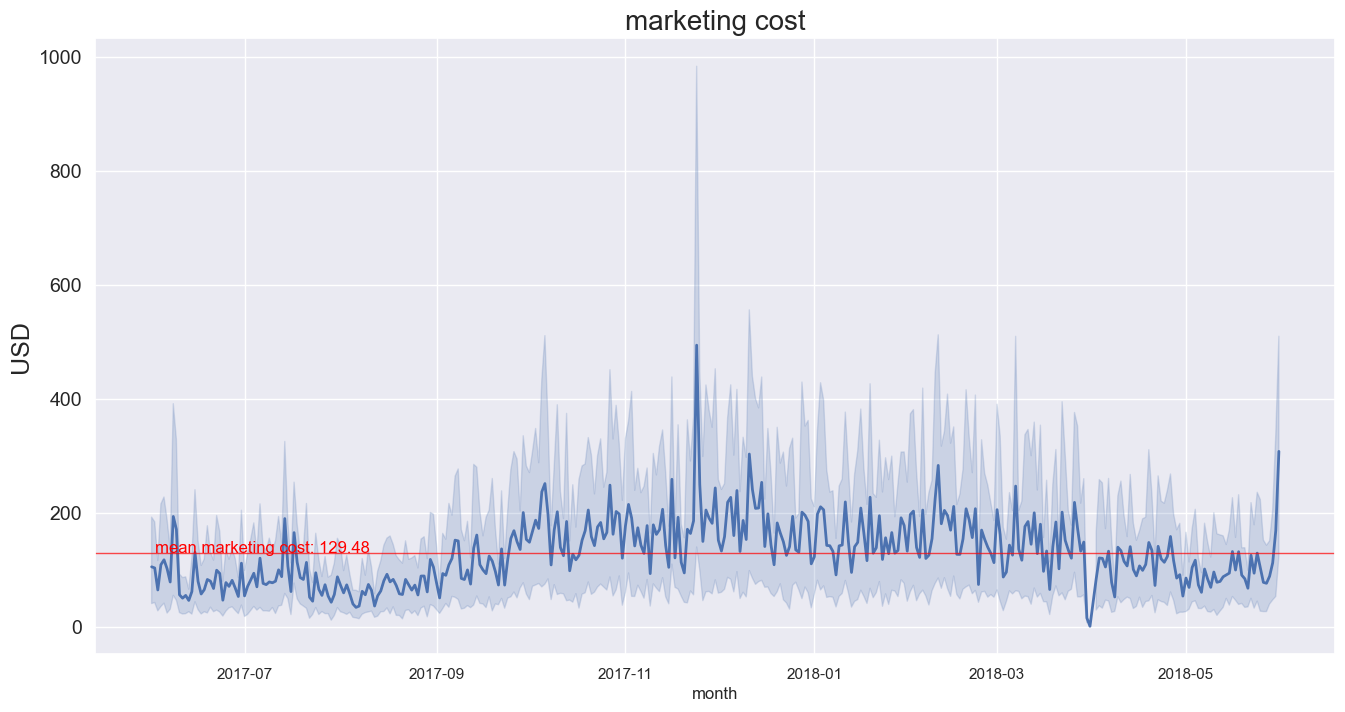

In [72]:
e = costs.costs.mean()
plt.figure(figsize=(16,8))
ax = sns.lineplot(data=costs, x="dt", y="costs", linewidth=2)
ax.grid(axis= 'both')

plt.axhline(y=e, linewidth=1, color = 'red', alpha = 0.7)
ax.text(costs['dt'].iloc[1], 
        e-0.1, f"mean marketing cost: {round(e, 2)}", color='red')


ax.set_title('marketing cost', fontsize=20)
ax.set_ylabel('USD', fontsize = 18)
ax.tick_params(axis='y', labelsize=14)
ax.set_xlabel('month');

We see here that in October costs started to grow with peak in December and then descended below average in April.

Now let's see what is happening with costs if we group it by month. But first we need to make month column.

In [73]:
costs['cost_month'] = costs['dt'].astype('datetime64[M]')
costs.head(5)

,source_id,dt,costs,cost_month
0,1,2017-06-01,75.20,2017-06-01
1,1,2017-06-02,62.25,2017-06-01
2,1,2017-06-03,36.53,2017-06-01
3,1,2017-06-04,55.00,2017-06-01
4,1,2017-06-05,57.08,2017-06-01


In [74]:
cost_by_month = costs.groupby('cost_month')['costs'].sum()
cost_by_month

cost_month
2017-06-01    18015.00
2017-07-01    18240.59
2017-08-01    14790.54
2017-09-01    24368.91
2017-10-01    36322.88
2017-11-01    37907.88
2017-12-01    38315.35
2018-01-01    33518.52
2018-02-01    32723.03
2018-03-01    30415.27
2018-04-01    22289.38
2018-05-01    22224.27
Name: costs, dtype: float64

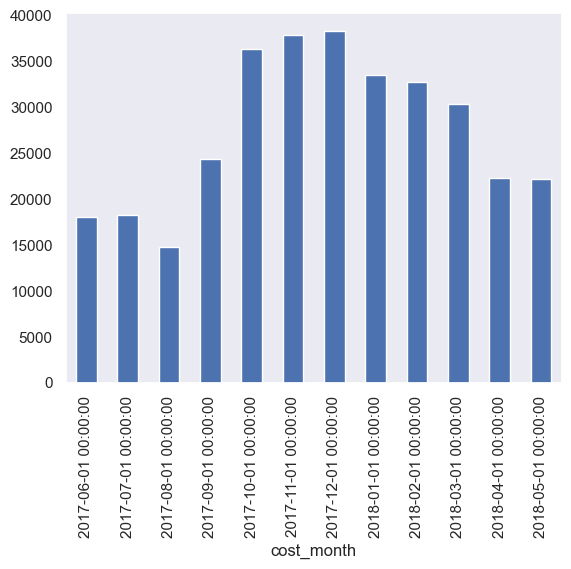

In [75]:
cost_by_month.plot(kind='bar');

We see that marketing expenses increased in October and stayed pretty high until March - we remember that the same happened with our active users - their number also increased in October and dropped in April.

We also could divide marketing expences by source in order to see how much money was spent on each sourse over the time.

In [76]:
monthly_cost_by_source = costs.groupby(['cost_month','source_id'])['costs'].sum().reset_index()
monthly_cost_by_source

,cost_month,source_id,costs
0,2017-06-01,1,1125.61
1,2017-06-01,2,2427.38
2,2017-06-01,3,7731.65
3,2017-06-01,4,3514.80
4,2017-06-01,5,2616.12
...,...,...,...
79,2018-05-01,3,9411.42
80,2018-05-01,4,4214.21
81,2018-05-01,5,3669.56
82,2018-05-01,9,362.17


In [77]:
monthly_cost_by_source_pivot = costs.pivot_table(
    index='source_id',
    columns='cost_month',
    values='costs',
    aggfunc='sum')
monthly_cost_by_source_pivot

cost_month,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01
source_id,,,,,,,,,,,,
1,1125.61,1072.88,951.81,1502.01,2315.75,2445.16,2341.20,2186.18,2204.48,1893.09,1327.49,1467.61
2,2427.38,2333.11,1811.05,2985.66,4845.00,5247.68,4897.80,4157.74,4474.34,3943.14,2993.70,2689.44
3,7731.65,7674.37,6143.54,9963.55,15737.24,17025.34,16219.52,14808.78,14228.56,13080.85,9296.81,9411.42
4,3514.80,3529.73,3217.36,5192.26,6420.84,5388.82,7680.47,5832.79,5711.96,5961.87,4408.49,4214.21
5,2616.12,2998.14,2185.28,3849.14,5767.40,6325.34,5872.52,5371.52,5071.31,4529.62,3501.15,3669.56
9,285.22,302.54,248.93,415.62,609.41,683.18,657.98,547.16,551.50,480.29,373.49,362.17
10,314.22,329.82,232.57,460.67,627.24,792.36,645.86,614.35,480.88,526.41,388.25,409.86


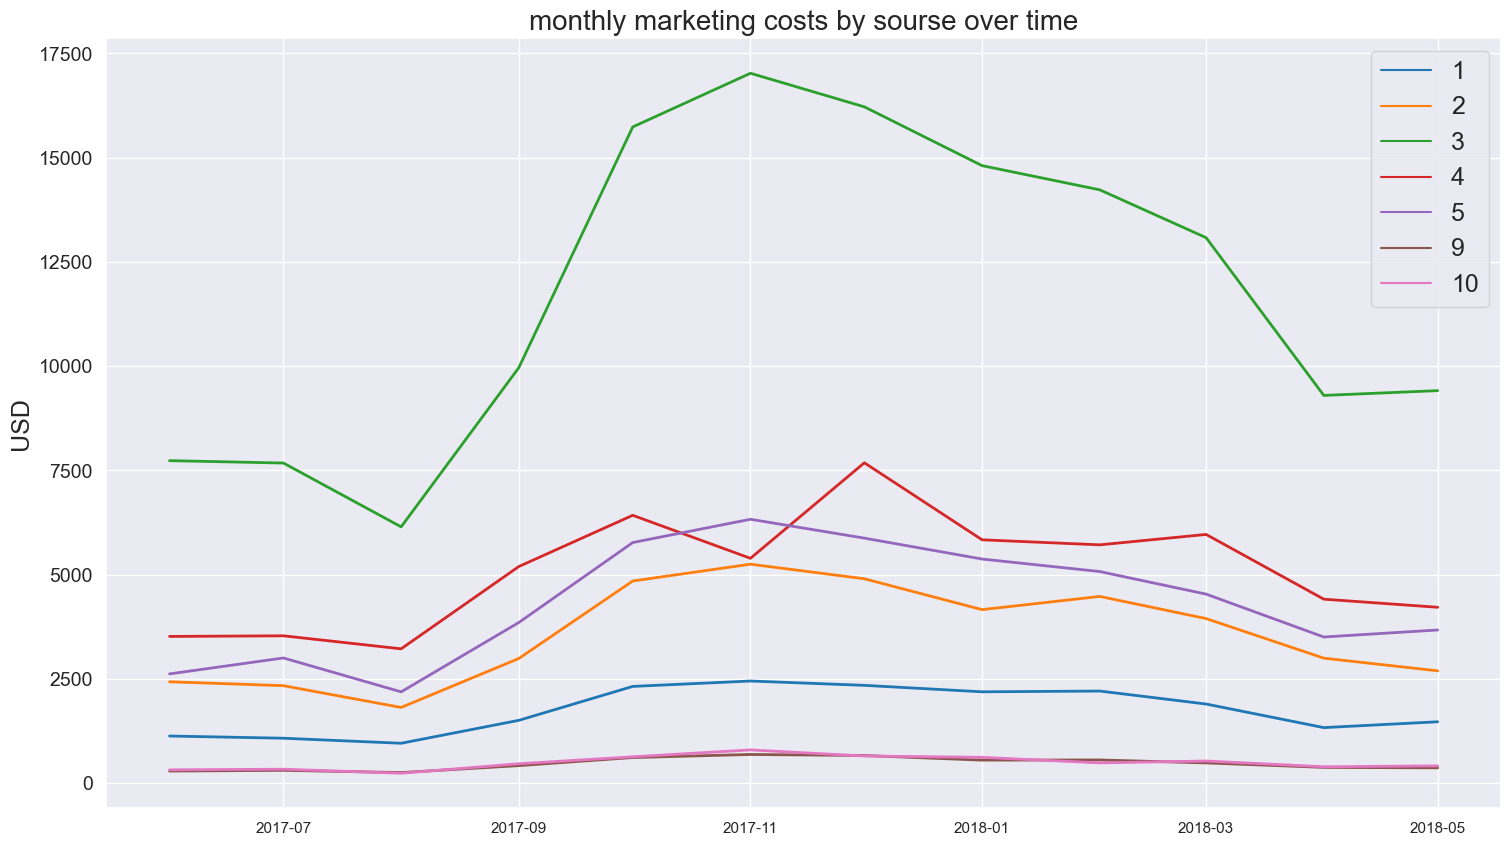

In [78]:
plt.figure(figsize=(18,10))
ax = sns.lineplot(data=monthly_cost_by_source, 
                  x="cost_month", 
                  y="costs",
                  hue="source_id", 
                  linewidth=2, 
                  palette=sns.color_palette("tab10", 7))
ax.grid(axis='both')
ax.set_title('monthly marketing costs by sourse over time', fontsize=20)
legend = ax.legend(fontsize=18)
ax.set_ylabel('USD', fontsize = 18)
ax.tick_params(axis='y', labelsize=14)
ax.set_xlabel(' ');

We see that the amount of money invested in a third ad source was bigger all the time comparing to other sources. 
There is also a noticeable growth in expenses on third source starting from September and decrease in March - looks like with this marketing source we could connect the rise in active users and/or increase in the number of buyers.

### 2. How much did customer acquisition cost?

All of the markening expences make sence if they are attracting customers. Let's see how much money were spent each month and how many customers were attracted on each month.

In [79]:
marketing_by_month = costs.groupby(['cost_month'])['costs'].sum().reset_index()
marketing_by_month.head()

,cost_month,costs
0,2017-06-01,18015.00
1,2017-07-01,18240.59
2,2017-08-01,14790.54
3,2017-09-01,24368.91
4,2017-10-01,36322.88


In [80]:
buyers_per_moth = orders.groupby(['first_order_month'])['uid'].nunique().reset_index()
buyers_per_moth.columns = ['cost_month','buyers']
buyers_per_moth.head()

,cost_month,buyers
0,2017-06-01,2023
1,2017-07-01,1923
2,2017-08-01,1370
3,2017-09-01,2581
4,2017-10-01,4340


Let's calculate customer acquisition cost by month and visualize it.

In [81]:
CAC_per_month = marketing_by_month.merge(buyers_per_moth,how='left',on=['cost_month'])
CAC_per_month['CAC'] = CAC_per_month['costs']/CAC_per_month['buyers']
CAC_per_month

,cost_month,costs,buyers,CAC
0,2017-06-01,18015.00,2023,8.905091
1,2017-07-01,18240.59,1923,9.485486
2,2017-08-01,14790.54,1370,10.796015
3,2017-09-01,24368.91,2581,9.441654
4,2017-10-01,36322.88,4340,8.369327
5,2017-11-01,37907.88,4081,9.288870
6,2017-12-01,38315.35,4383,8.741809
7,2018-01-01,33518.52,3373,9.937302
8,2018-02-01,32723.03,3651,8.962758
9,2018-03-01,30415.27,3533,8.608907


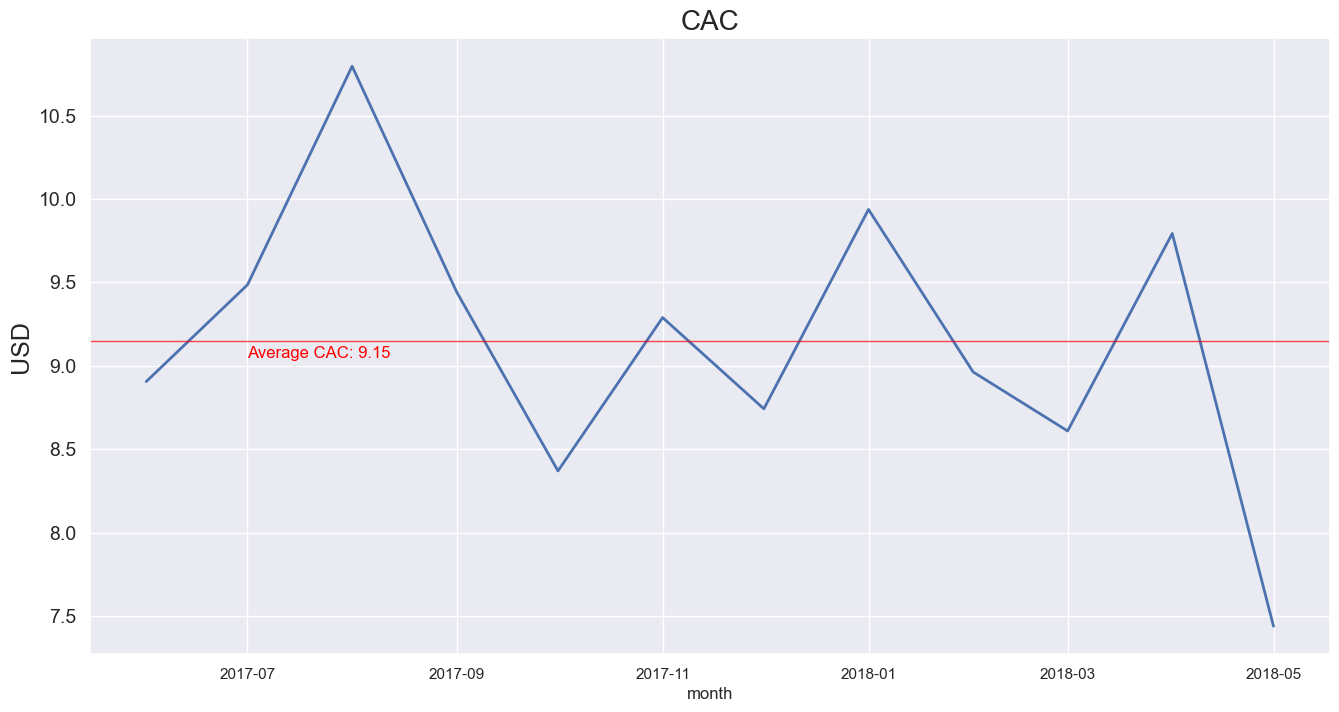

In [82]:
f=CAC_per_month.CAC.mean()

plt.figure(figsize=(16,8))
ax = sns.lineplot(data=CAC_per_month, x="cost_month", y="CAC", linewidth=2)
ax.grid(axis= 'both')


plt.axhline(y=f, linewidth=1, color = 'red', alpha = 0.7)
ax.text(CAC_per_month['cost_month'].iloc[1], 
        f-0.1, f"Average CAC: {round(f, 2)}", color='red')

ax.set_title('CAC', fontsize=20)
ax.set_ylabel('USD', fontsize = 18)
ax.tick_params(axis='y', labelsize=14)
ax.set_xlabel('month');

Overall average customer acquisition cost is 9.15USD per customer. And if we look at how CAC changed in time we can see that CAC varies from 7.4 to 10.8USD. The highest peak is in August - CAC is 10.8USD. There are also peaks in January and April.

### 2.a How much did customer acquisition from each of the sources cost?

Let's also take a look at CAC per ad source. We saw how much marketing expences were different for different sources and it would be logical to investigate customer acquisition cost taking into account from where we've got this customer. 

First, we need to find source for each user id. For that we need our visits table.

In [83]:
first_source = visits.sort_values('start_ts').groupby('uid').first()['source_id'].reset_index()
first_source.columns=['uid','first_source']
first_source.head()

,uid,first_source
0,11863502262781,3
1,49537067089222,2
2,297729379853735,3
3,313578113262317,2
4,325320750514679,5


Then add this information to orders table.

In [84]:
orders = orders.merge(first_source,on=['uid'],how='left')
orders.head()

,buy_ts,revenue,uid,order_date,first_order_date,first_session_date,conversion,order_month,first_order_month,first_source
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01,2017-06-01,0,2017-06-01,2017-06-01,1
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01,2017-06-01,0,2017-06-01,2017-06-01,2
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01,2017-06-01,0,2017-06-01,2017-06-01,2
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01,2017-06-01,0,2017-06-01,2017-06-01,2
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01,2017-06-01,0,2017-06-01,2017-06-01,3


Then group it by month and source, counting number of buyers.

In [85]:
buyers_per_moth_source = orders.groupby(['first_order_month','first_source'])['uid'].nunique().reset_index()
buyers_per_moth_source.columns = ['cost_month','source_id','buyers']
buyers_per_moth_source.head()

,cost_month,source_id,buyers
0,2017-06-01,1,190
1,2017-06-01,2,235
2,2017-06-01,3,638
3,2017-06-01,4,413
4,2017-06-01,5,384


We also need to do same grouping in costs table, but this time we sum costs.

In [86]:
marketing_by_month_source = costs.groupby(['cost_month','source_id'])['costs'].sum().reset_index()
marketing_by_month_source.columns = ['cost_month', 'source_id', 'costs']
marketing_by_month_source.head()

,cost_month,source_id,costs
0,2017-06-01,1,1125.61
1,2017-06-01,2,2427.38
2,2017-06-01,3,7731.65
3,2017-06-01,4,3514.80
4,2017-06-01,5,2616.12


Now we have everything to calculate CAC - we divide montly marketing expences to numer of buyers.

In [87]:
CAC_per_month_source = marketing_by_month_source.merge(buyers_per_moth_source, 
                                                       how='left', 
                                                       on=['cost_month','source_id'])
CAC_per_month_source['CAC'] = CAC_per_month_source['costs']/CAC_per_month_source['buyers']
CAC_per_month_source.head()

,cost_month,source_id,costs,buyers,CAC
0,2017-06-01,1,1125.61,190,5.924263
1,2017-06-01,2,2427.38,235,10.329277
2,2017-06-01,3,7731.65,638,12.118574
3,2017-06-01,4,3514.80,413,8.510412
4,2017-06-01,5,2616.12,384,6.812812


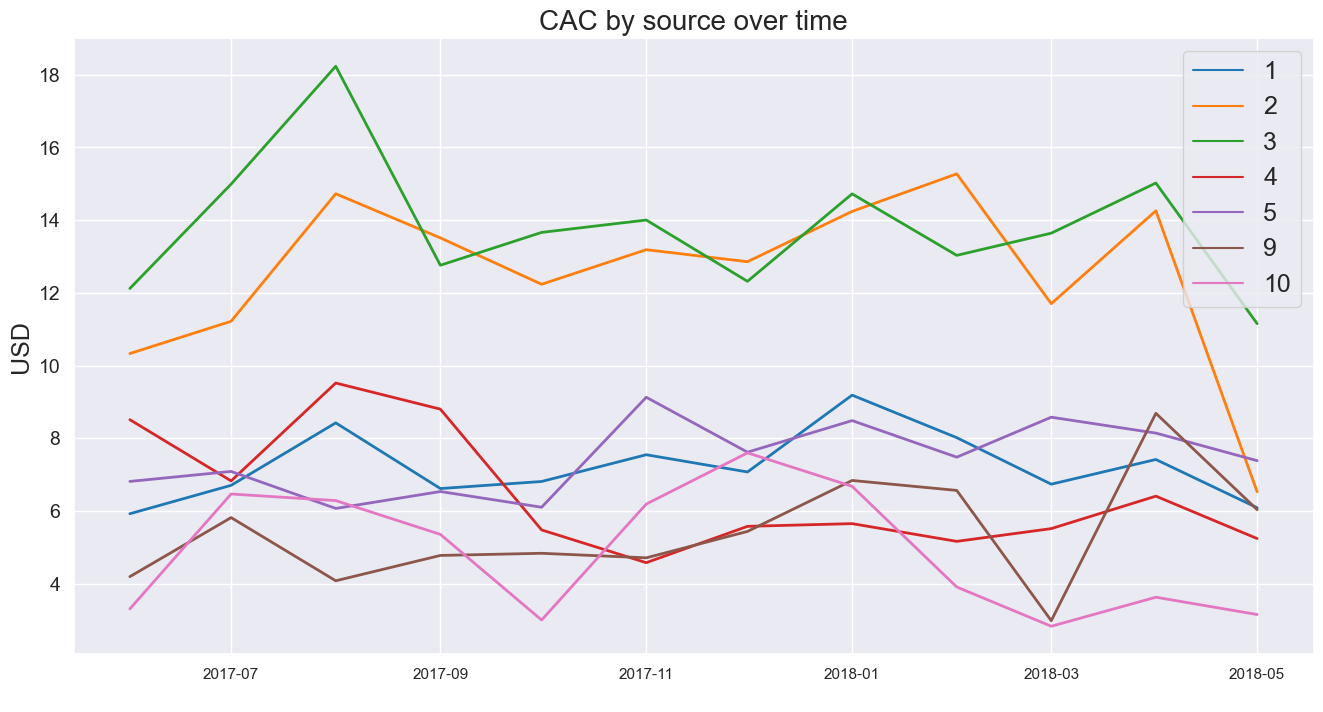

In [88]:
plt.figure(figsize=(16,8))
ax = sns.lineplot(data=CAC_per_month_source, 
                  x="cost_month", 
                  y="CAC",
                  hue="source_id", 
                  linewidth=2, 
                  palette=sns.color_palette("tab10", 7))
ax.grid(axis='both')
ax.set_title('CAC by source over time', fontsize=20)
legend = ax.legend(fontsize=18)
ax.set_ylabel('USD', fontsize = 18)
ax.tick_params(axis='y', labelsize=14)
ax.set_xlabel(' ');

The graph here shows two groups - CAC by second and third ad source is higher - it costs between 10 and 18USD, and the rest of CAC by sources are between 2 and 10.

Let's look at average CAC by source.

In [89]:
CAC_source_mean = CAC_per_month_source.groupby(['source_id'])['CAC'].mean().reset_index()
CAC_source_mean

,source_id,CAC
0,1,7.212107
1,2,12.504068
2,3,13.802743
3,4,6.439374
4,5,7.451938
5,9,5.413892
6,10,4.867125


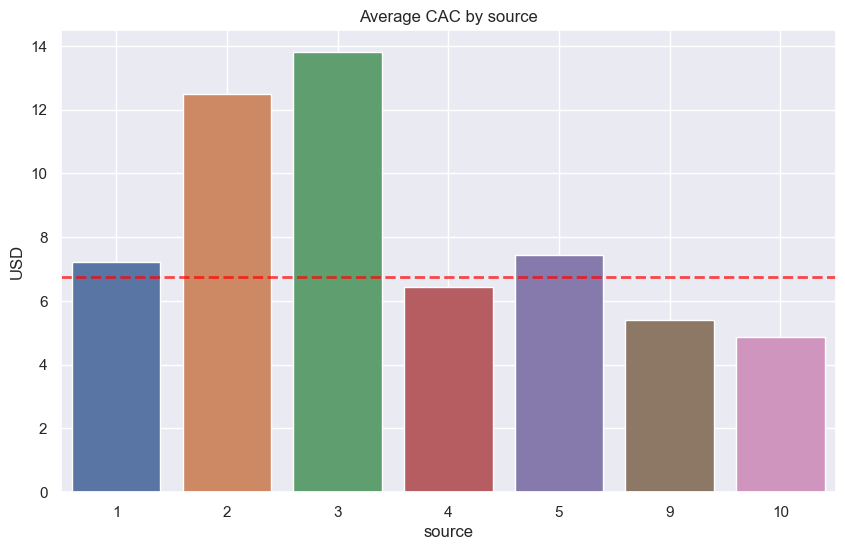

In [90]:
h = CAC_source_mean.CAC.mean()
plt.figure(figsize = (10,6))
ax = sns.barplot(data=CAC_source_mean, 
                 x='source_id', 
                 y='CAC',
                 linewidth=1)
ax.grid(axis='both')

plt.axhline(y=b, linewidth=2, color = 'red', alpha = 0.7, linestyle = '--')


ax.set_title('Average CAC by source')
ax.set_xlabel('source')
ax.set_ylabel('USD');

As we can see here the second and the third ad sources have higher average CAC.

### 3. How worthwhile were the investments? (ROI)

And now we are getting closer to the most important part - we want to know if our marketing expences paid off.

### 3.a. ROI per cohort

We want to know if our cohorts brought more money than it wes spent on its acquisition. 
First we'll merge all nesessery data in one table.

In [91]:
CAC_per_month_ROI = CAC_per_month[['cost_month','CAC']]
CAC_per_month_ROI.columns = ['first_order_month','CAC']
ROI = ltv_cohort.merge(CAC_per_month_ROI,on=['first_order_month'],how='left')
ROI.head()

,first_order_month,order_month,revenue,cohort_size,age,ltv,CAC
0,2017-06-01,2017-06-01,9557.49,2023,0.0,4.724414,8.905091
1,2017-06-01,2017-07-01,981.82,2023,1.0,0.485329,8.905091
2,2017-06-01,2017-08-01,885.34,2023,2.0,0.437637,8.905091
3,2017-06-01,2017-09-01,1931.30,2023,3.0,0.954671,8.905091
4,2017-06-01,2017-10-01,2068.58,2023,4.0,1.022531,8.905091


Then we'll calculate return of investment coefficient (ROI) as a ratio LTV and CAC. And visualize it with heatmap.

In [92]:
ROI['ROI']=ROI['ltv']/ROI['CAC']
roi_piv = ROI.pivot_table(
    index='first_order_month', 
    columns='age', 
    values='ROI', 
    aggfunc='mean'
).cumsum(axis=1).round(2) 
roi_piv.index = roi_piv.index.to_series().dt.strftime('%Y-%m')

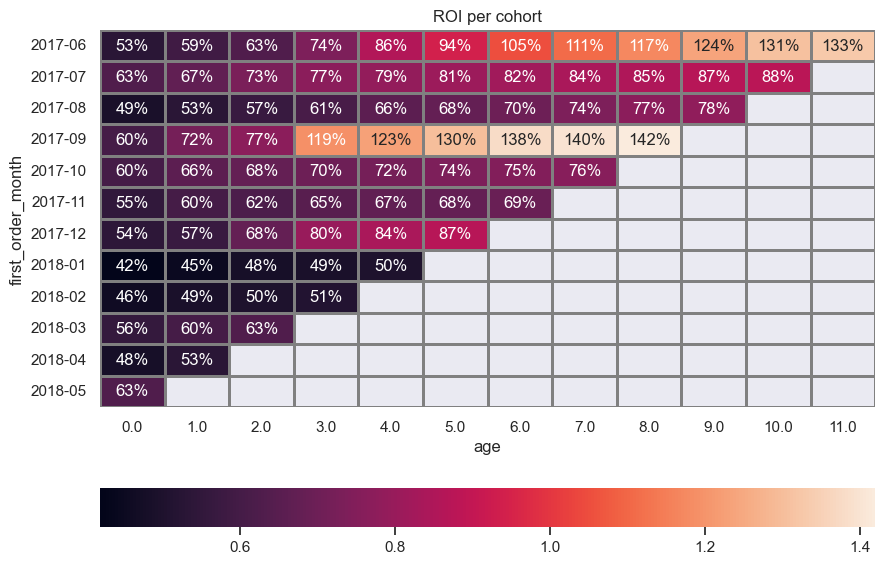

In [93]:
plt.figure(figsize=(10, 7))

sns.heatmap(roi_piv, 
            annot=True, 
            fmt='.0%', 
            linewidths=1, 
            linecolor='grey', 
            cbar_kws= {'orientation': 'horizontal'} 
            ).set(title ='ROI per cohort');

We see here that only two cohorts paid off - September cohort with 42% profitability and June cohort with 33% profitability.
The September cohort started to pay off from its fourth month (we remember that it was month - December - when this cohort's average check seriously increased). The June cohort paid off in its 7th month(also December).
There are also two cohorts that are getting closer to being profitable - July and December.

### 3.b. ROI per source

Besides cohorts profitability we would also want to know if all our ad sources are bringing us enough customers to cover expenses.

In [94]:
ltv_per_source = orders.groupby(['first_source'])['uid','revenue'].agg(
    {'uid':'nunique','revenue':'sum'}).reset_index()
ltv_per_source.columns = ['source_id','buyers','revenue']
ltv_per_source['ltv'] = ltv_per_source['revenue']/ltv_per_source['buyers']
ltv_per_source

/var/folders/z1/lvsblrmx5g17yg0rptmhn8wr0000gn/T/ipykernel_7219/1187660995.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  ltv_per_source = orders.groupby(['first_source'])['uid','revenue'].agg(


,source_id,buyers,revenue,ltv
0,1,2899,31090.55,10.724577
1,2,3506,46923.61,13.383802
2,3,10473,54511.24,5.204931
3,4,10296,56696.83,5.506685
4,5,6931,52624.02,7.592558
5,7,1,1.22,1.220000
6,9,1088,5759.40,5.293566
7,10,1329,4450.33,3.348631


In [95]:
roi_per_source = cost_by_source.merge(ltv_per_source,on=['source_id'])
roi_per_source['cac'] = roi_per_source['costs']/roi_per_source['buyers']
roi_per_source['romi'] = roi_per_source['ltv']/roi_per_source['cac']
roi_per_source

,source_id,costs,buyers,revenue,ltv,cac,romi
0,1,20833.27,2899,31090.55,10.724577,7.186364,1.492351
1,2,42806.04,3506,46923.61,13.383802,12.209367,1.096191
2,3,141321.63,10473,54511.24,5.204931,13.493901,0.385725
3,4,61073.60,10296,56696.83,5.506685,5.931779,0.928336
4,5,51757.10,6931,52624.02,7.592558,7.467479,1.016750
5,9,5517.49,1088,5759.40,5.293566,5.071222,1.043844
6,10,5822.49,1329,4450.33,3.348631,4.381106,0.764335


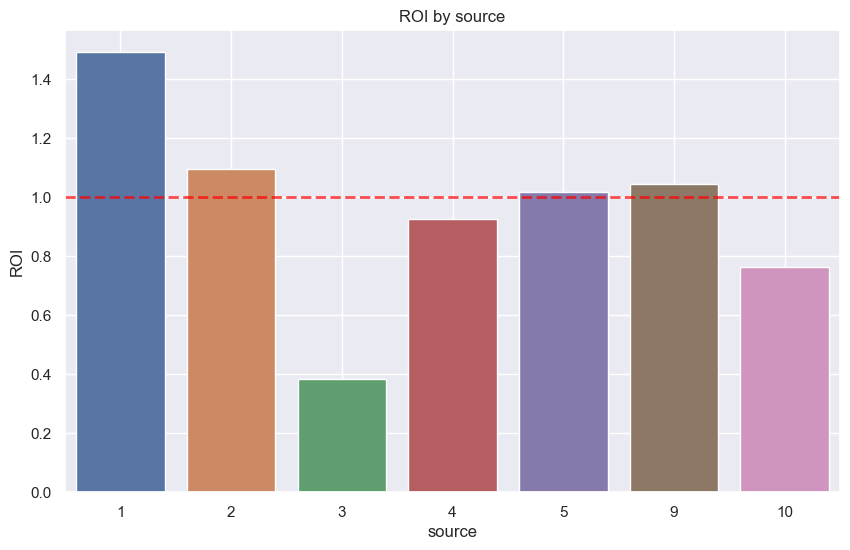

In [96]:
plt.figure(figsize = (10,6))
ax = sns.barplot(data=roi_per_source, 
                 x='source_id', 
                 y='romi',
                 linewidth=1)
ax.grid(axis='both')

plt.axhline(y=1, linewidth=2, color = 'red', alpha = 0.7, linestyle = '--')

ax.set_title('ROI by source')
ax.set_xlabel('source')
ax.set_ylabel('ROI');

1,2,5,9 ad sources paid off - they attracted customers and covered expenses. The rest of them showed themself as not profitable. The least source in terms of profit is the third source - the most expensive one. We definitely need to look into that.

In [97]:
costs_not_paid_off = costs.query('source_id in (3,4,10)')['costs'].sum()
round(costs_not_paid_off,2)

208217.72

In [98]:
print(round(costs_not_paid_off/overall_expenses*100, 1), "% of marketing expenses didn't pay off")

63.3 % of marketing expenses didn't pay off


### Marketing summary

#### 1. How much money was spent? Overall, per source and over time.

Total marketing cost is 329131.62 USD.
The third source is the most expensive one - more than 141K were spent on it.

If we look at the changes in marketing expenses over the time we see that they increased in October and stayed pretty high until March - we remember that the same happened with our active users - their number also increased in October and dropped in April.

If we look at how marketing expenses changed by each source over the time we see that the amount of money invested in a third ad source was bigger all the time compared to other sources. There is also a noticeable growth in expenses on third source starting from September and decrease in March - looks like with this marketing source we could connect the rise in active users and increase in the number of buyers cohorts from this period.

#### 2. How much did customer acquisition cost?

Overall average customer acquisition cost is 9.15USD per customer. And if we look at how CAC changed in time we can see that CAC varies from 7.4 to 10.8USD. The highest peak is in August - CAC is 10.8USD. There are also peaks in January and April.

If we look at how CAC varies from source to source we can see two groups - CAC by second and third ad source is higher - it costs between 10 and 18USD, and the rest of CAC by sources are between 2 and 10.
As we also see that the second and the third ad sources have higher average CAC - 12.5USD and 13.8USD respectively.

#### 3. How worthwhile were the investments? (ROI)

#### ROI per cohort.

We see here that only two cohorts paid off - September cohort with 42% profitability and June cohort with 33% profitability. The September cohort started to pay off from its fourth month (we remember that it was month - December - when this cohort's average check seriously increased). The June cohort paid off in its 7th month(also December). There are also two cohorts that are getting closer to being profitable - July and December.

#### ROI per source.

1,2,5,9 ad sources paid off - they attracted customers and covered expenses. The rest of them showed themself as not profitable. The least source in terms of profit is the third source - the most expensive one. We definitely need to look into that.

#### Sum of investments in the unprofitable ad sources is  more than 208K USD and this is 63% of all marketing costs.

### Overall Conclusion

After conducting our analysis, several issues were brought to light.
#### 1. Product
* Low sticky factor in active users. Not many visitors use our service frequently.
* Low retention rate in cohorts. People who started using our service rarely keep using it for a long time. 

It definitely has something to do with our service performance or user's engagement - new visitors are attracted to it, but for some reason they are not staying for long. 

#### 2. Sales
* Low conversion. There are two things about conversion - one is a good thing and the other is not.
Good thing is that at least half of the orders happened on the same day as the first visit and the bad one - just 16% of visitors became buyers. 

#### 3. Marketing
* Return of investments in users. As we saw from our calculations just 2 out of 11 cohorts paid off. 9 cohorts were unprofitable - acquisition cost of customers turned out to be bigger than their lifetime value.
* Return of marketing investment. Out of 7 ad sources 4 paid off. But the sum of the investments in unprofitable ad sources is 208K USD and this is 63% of all marketing costs.

So the first problem that needs to be addressed is how to increase users' engagement with our service - it should help with retention of visitors and conversion of visitors to customers. More customers mean more orders which leads to better profitability. 
The second problem is optimizing marketing expenses and redirecting these expenses from unprofitable advertising sources to profitable ones.